# Imports

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_function(func, x_range):
    """
    Построение 2D графика функции.

    Параметры:
    func (callable): функция, которую нужно отобразить.
    x_range (tuple): диапазон x (min, max).
    """
    x = np.linspace(x_range[0], x_range[1], 400)
    y = func(x)

    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    plt.title('График функции')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()


# Triplet  RM evaluation notebook

## Plan

1. Test SO/gen ratio
2. Точность
    - Общая
    - По сгеренированным
    - По SO
3. Распределения `dot_prod`, `cos_sim`, `euclidean`
4. Корреляция между `log_score` и `cos_sim` / `euclidean` / `dot_prod`
5. Распределение наград в процессе обучения

## Test subset SO/gen ration

## Comparison

### Stack Overflow - Paraphrased

#### Helper functions

In [1]:
import ppscore as pps

In [14]:
def calculate_correlations(df):
    # Комбинации ответов
    combinations = [
        ('so', 'so'),
        ('so', 'par'),
        ('par', 'so'),
        ('par', 'par')
    ]
    terms = ['dot_prod', 'cos_sim', 'euclidean']
    
    correlation_data = []
    available_combinations = []
    
    for comb in combinations:
        mask = (df['is_par_j'] == (comb[0] == 'par')) & (df['is_par_k'] == (comb[1] == 'par'))
        subset_df = df[mask]
        
        # Если нет такой комбинации, пропускаем
        if subset_df.empty:
            continue
        
        available_combinations.append(comb)
        comb_data = []
        for term in terms:
            # получаем название колонок
            col_name_term_j = f"{term}_j"
            col_name_term_k = f"{term}_k"
            col_name_log_score_j = f"log_score_j"
            col_name_log_score_k = f"log_score_k"

            # вычисляем корреляции
            correlation_j = subset_df[col_name_log_score_j].corr(subset_df[col_name_term_j])
            correlation_k = subset_df[col_name_log_score_k].corr(subset_df[col_name_term_k])
            # correlation_j = pps.score(subset_df, col_name_log_score_j, col_name_term_j)['ppscore']
            # correlation_k = pps.score(subset_df, col_name_log_score_k, col_name_term_k)['ppscore']
            
            comb_data.append(correlation_j)
            comb_data.append(correlation_k)
        
        correlation_data.append(comb_data)
    
    correlation_df = pd.DataFrame(correlation_data, columns=[f"{term}_j" for term in terms] + [f"{term}_k" for term in terms], index=[f"{comb[0]} & {comb[1]}" for comb in available_combinations])
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlations")
    plt.tight_layout()
    plt.show()


def accuracy_report(df, name, quality_mesure='cos_sim'):
    # Комбинации ответов
    combinations = [
        ('so', 'so'),
        ('so', 'par'),
        ('par', 'so'),
        ('par', 'par')
    ]
    
    print(f"Accuracy Report for {name}:\n")
    accuracies = {}
    for comb in combinations:
        mask = (df['is_par_j'] == (comb[0] == 'par')) & (df['is_par_k'] == (comb[1] == 'par'))
        subset_df = df[mask]
        
        # Если нет такой комбинации, пропускаем
        if subset_df.empty:
            continue
        
        if quality_mesure == 'euclidean':
            accuracy = (subset_df[f'{quality_mesure}_j'] < subset_df[f'{quality_mesure}_k']).mean()
        else:
            accuracy = (subset_df[f'{quality_mesure}_j'] > subset_df[f'{quality_mesure}_k']).mean()

        accuracies[comb] = accuracy
        print(f"Accuracy for j={comb[0]} and k={comb[1]}: {accuracy*100:.2f}%")
    
    # Вычисляем общую точность
    if quality_mesure == 'euclidean':
        overall_accuracy = (df[f'{quality_mesure}_j'] < df[f'{quality_mesure}_k']).mean()
    else:
        overall_accuracy = (df[f'{quality_mesure}_j'] > df[f'{quality_mesure}_k']).mean()
    print(f"\nOverall Accuracy: {overall_accuracy*100:.2f}%")
    print(f"Avg. accuracy {(sum(accuracies.values())/len(accuracies))*100:.2f}%")
    
    calculate_correlations(df)
    
    # Генерируем круговые диаграммы и столбчатую диаграмму
    df['combination'] = df.apply(lambda x: ('Par' if x['is_par_j'] else 'SO') + ' & ' + ('Par' if x['is_par_k'] else 'SO'), axis=1)
    df['correct_prediction'] = (df[f'{quality_mesure}_j'] > df[f'{quality_mesure}_k']).astype(int)
    
    fig, ax = plt.subplots(1, len(accuracies) + 1, figsize=(20, 6))
    
    for i, comb in enumerate(accuracies.keys()):
        subset_df = df[(df['is_par_j'] == (comb[0] == 'par')) & (df['is_par_k'] == (comb[1] == 'par'))]
        correct_predictions = subset_df['correct_prediction'].value_counts()
        ax[i].pie(correct_predictions, labels=['Correct', 'Incorrect'], autopct='%1.1f%%')
        ax[i].set_title(f"{comb[0]} & {comb[1]}")
        
    # Генерируем столбчатую диаграмму для наглядности распределения верных/неверных предсказаний
    sns.countplot(x='combination', hue='correct_prediction', data=df, ax=ax[-1])
    ax[-1].set_title('Accuracy distribution')
    
    plt.suptitle(f"Accuracy distribution per combination for {name}")
    plt.tight_layout()
    plt.show()


def plot_distribution(df):
    # Комбинации ответов
    combinations = [
        ('so', 'so'),
        ('so', 'par'),
        ('par', 'so'),
        ('par', 'par')
    ]
    terms = ['dot_prod', 'cos_sim', 'euclidean']
    
    available_combinations = [comb for comb in combinations if not df[(df['is_par_j'] == (comb[0] == 'par')) & (df['is_par_k'] == (comb[1] == 'par'))].empty]
    
    fig, ax = plt.subplots(len(available_combinations), len(terms), figsize=(20, 6 * len(available_combinations)))
    
    if len(available_combinations) == 1:  # if we have only one combination, ax will not be 2D, so we wrap it into a list
        ax = [ax]
    
    for idx, comb in enumerate(available_combinations):
        mask = (df['is_par_j'] == (comb[0] == 'par')) & (df['is_par_k'] == (comb[1] == 'par'))
        subset_df = df[mask]
        
        for i, term in enumerate(terms):
            col_name_j = f"{term}_j"
            col_name_k = f"{term}_k"
            
            sns.histplot(subset_df[col_name_j], ax=ax[idx][i], kde=True, label=f"j ({comb[0]})")
            sns.histplot(subset_df[col_name_k], ax=ax[idx][i], kde=True, label=f"k ({comb[1]})")
            ax[idx][i].legend()
            ax[idx][i].set_title(f"Distribution of {term} for {comb[0]} & {comb[1]}")
    
    plt.tight_layout()
    plt.show()

#### Analysis

In [10]:
so_par_test_dot_prod_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/dot_prod_sim/test-mpnet-so_par-lr_2e5-not_norm-so_margin_5-dot_prod_sim-fr_1_10_11.csv")
so_par_test_cos_dist_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/cos_dist/test-mpnet-so_par-lr_2e5-norm-so_margin_5-cos_dist-fr_1_10_11.csv")

In [11]:
(0.44+0.36+0.28)/3

0.36000000000000004

Accuracy Report for SO_Paraphrased_trained-cos_dist-256_a_length:

Accuracy for j=so and k=so: 91.33%
Accuracy for j=so and k=par: 97.96%
Accuracy for j=par and k=par: 98.03%

Overall Accuracy: 97.00%
Avg. accuracy 95.77%


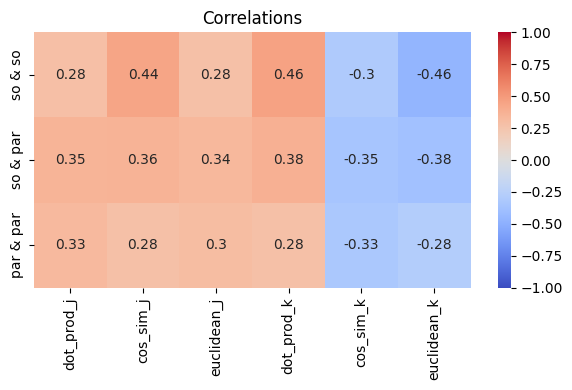

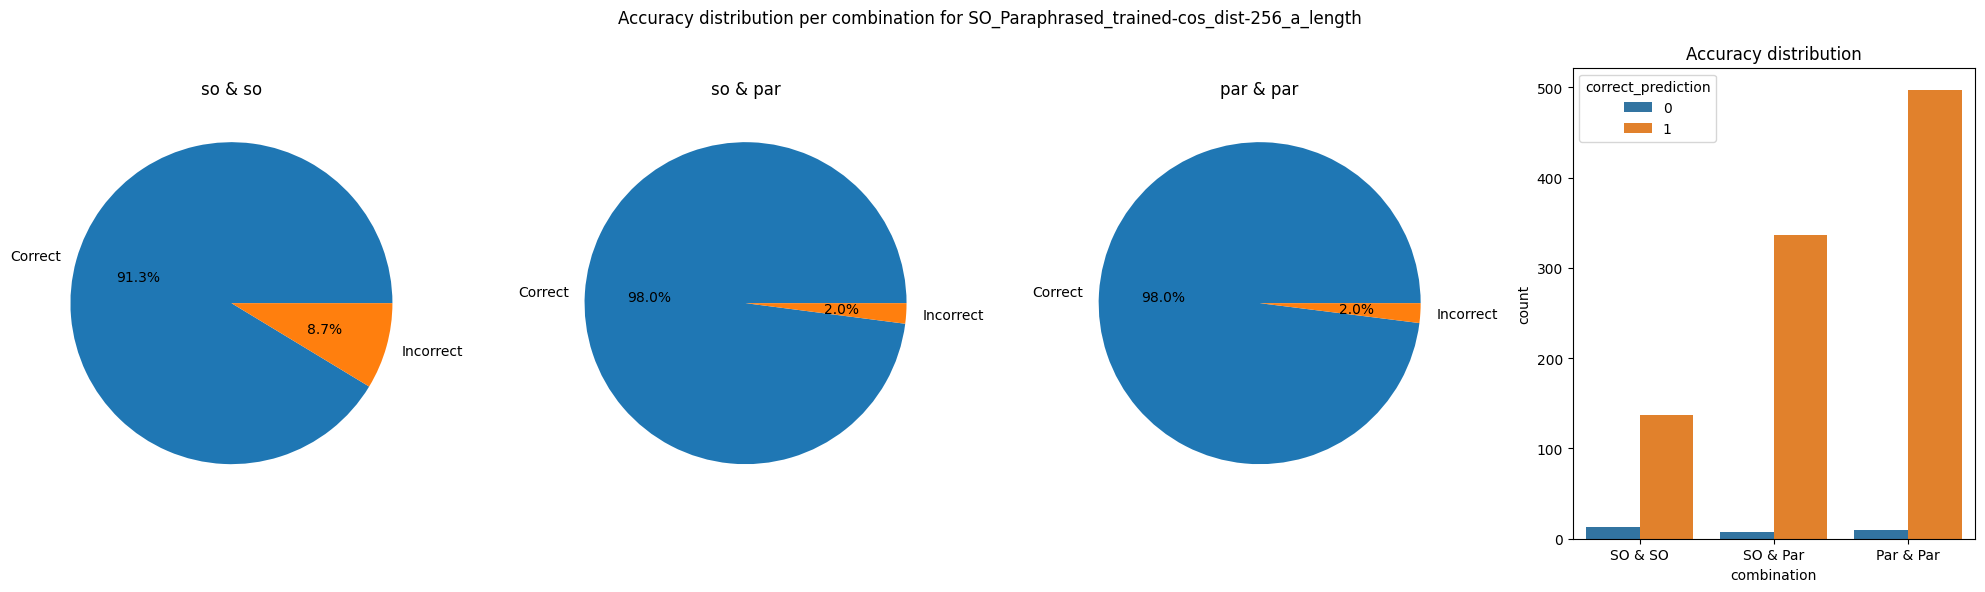

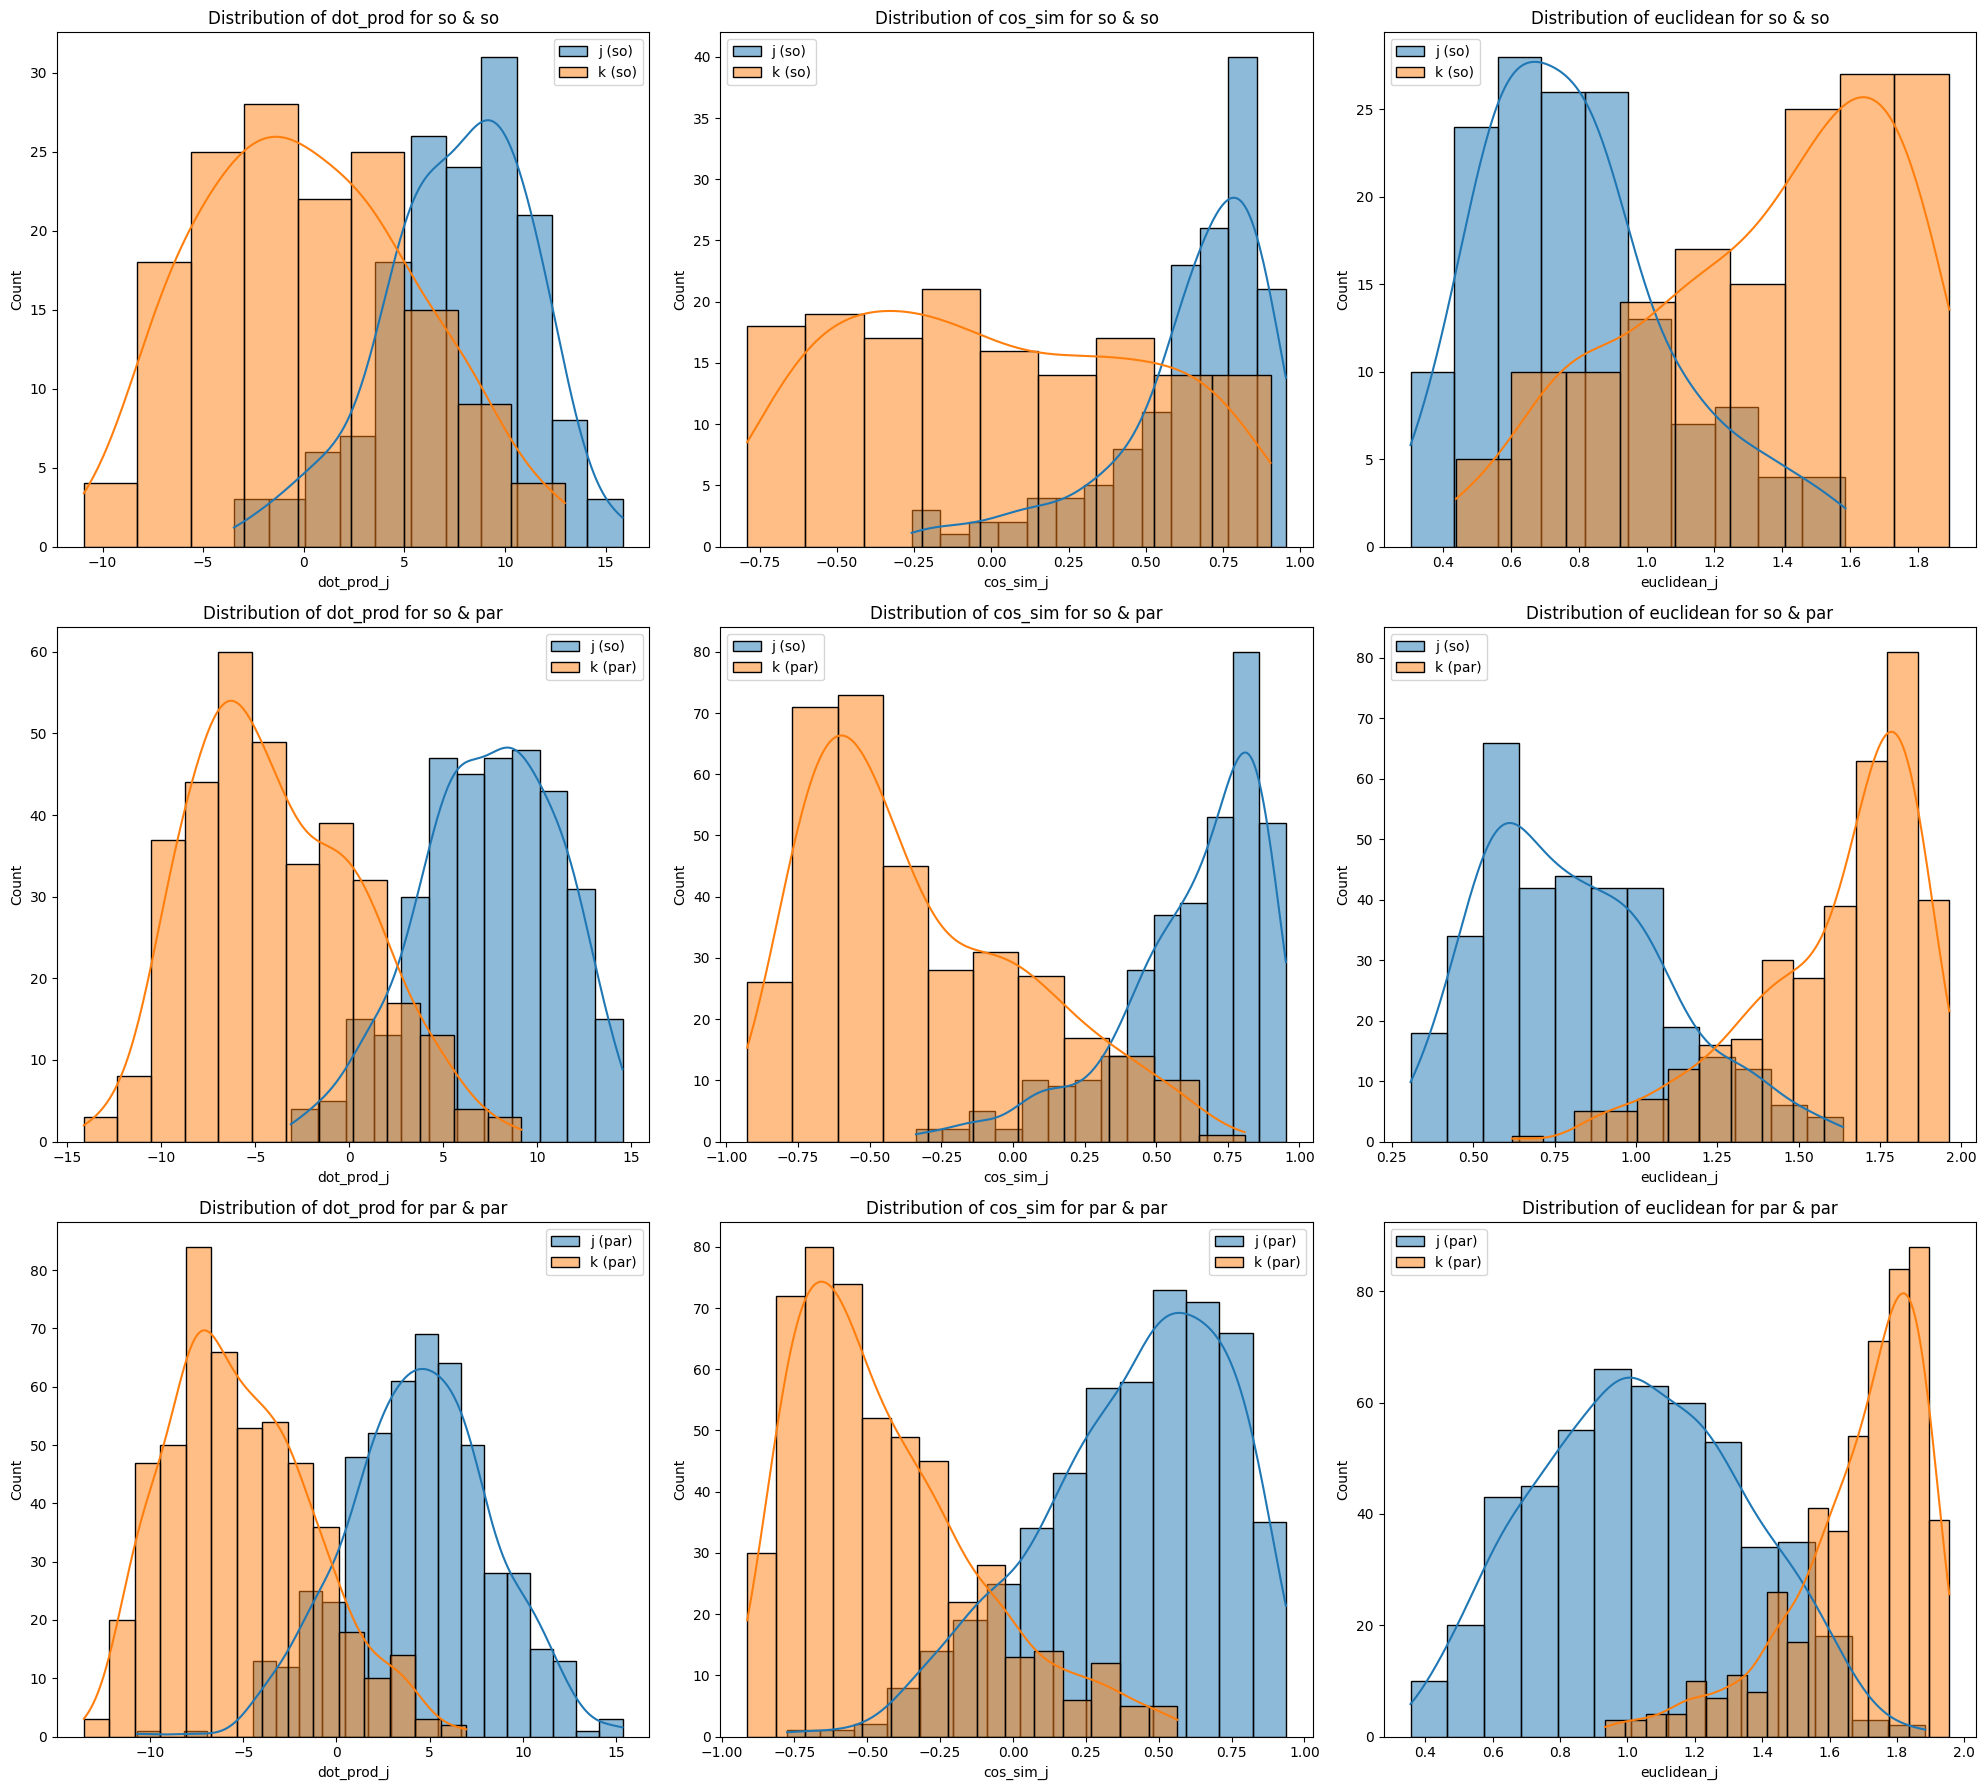

In [15]:
accuracy_report(so_par_test_cos_dist_df, "SO_Paraphrased_trained-cos_dist-256_a_length", quality_mesure='cos_sim')
plot_distribution(so_par_test_cos_dist_df)

Accuracy Report for SO_Paraphrased_trained-dot_prod-256_a_length:

Accuracy for j=so and k=so: 94.67%
Accuracy for j=so and k=par: 100.00%
Accuracy for j=par and k=par: 99.80%

Overall Accuracy: 99.10%
Avg. accuracy 98.16%


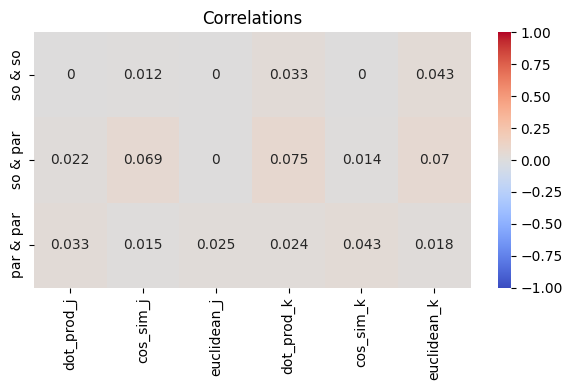

ValueError: 'label' must be of length 'x'

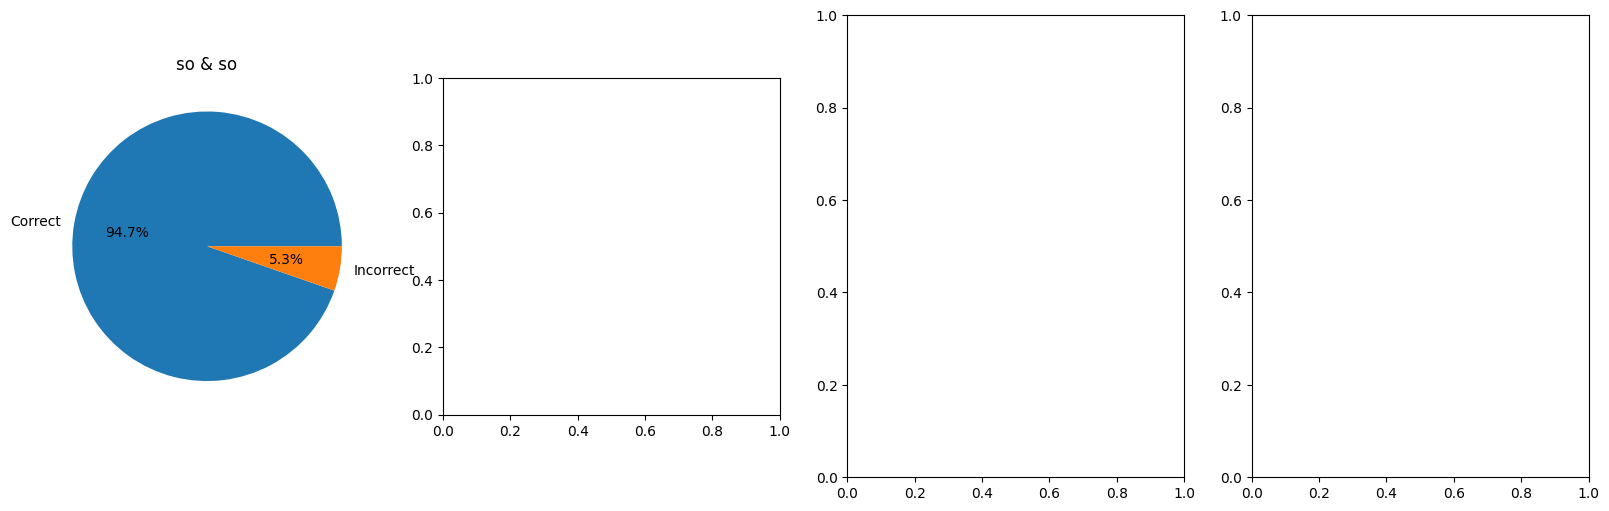

In [13]:
accuracy_report(so_par_test_dot_prod_df, "SO_Paraphrased_trained-dot_prod-256_a_length", quality_mesure='dot_prod')
plot_distribution(so_par_test_dot_prod_df)

### Stack Overflow - Generated

#### Helper fucntions

In [3]:
def calculate_correlations(df):
    # создаем список суффиксов
    suffixes = ['k', 'j']
    # создаем список основных терминов для вычисления корреляции
    terms = ['dot_prod', 'cos_sim', 'euclidean']

    for suffix in suffixes:
        if suffix == 'j':
            type = 'positive'
        else:
            type = 'negative'
    
        print(f"\nCorrelations for {type}:")
        for term in terms:
            # получаем название колонок
            col_name_term = f"{term}_{suffix}"
            col_name_log_score = f"log_score_{suffix}"

            # вычисляем корреляцию
            correlation = df[col_name_log_score].corr(df[col_name_term])
            print(f"Correlation between log_score and {term}: {correlation:.2f}")


In [13]:
def accuracy_report(df, name):
    df['accuracy'] = df.apply(lambda row: 1 if row['cos_sim_j'] > row['cos_sim_k'] else 0, axis=1)

    overall_accuracy = df['accuracy'].mean()
    
    accuracies = []
    for class_name in df['is_gen_k'].unique():
        class_df = df[df['is_gen_k'] == class_name]
        class_accuracy = class_df['accuracy'].mean()
        class_name_str = 'Stack Overflow' if class_name == 0 else 'Generated'
        print(f"Accuracy for {class_name_str}: {class_accuracy*100:.2f}%")
        accuracies.append(class_accuracy)
    
    # Вычисляем среднюю точность по классам
    avg_class_accuracy = sum(accuracies) / len(accuracies)
    print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
    print()
    print(f"Average Class Accuracy: {avg_class_accuracy*100:.2f}%")

    calculate_correlations(df)
    
    # Генерируем круговые диаграммы и столбчатую диаграмму
    df['class'] = df['is_gen_k'].apply(lambda x: 'Stack Overflow' if x == 0 else 'Generated')
    fig, ax = plt.subplots(1, df['class'].nunique()+1, figsize=(20, 6))
    
    for i, class_name in enumerate(df['class'].unique()):
        class_df = df[df['class'] == class_name]
        correct_predictions = class_df['accuracy'].value_counts()
        ax[i].pie(correct_predictions, labels=['Correct', 'Incorrect'], autopct='%1.1f%%')
        ax[i].set_title(f"{class_name}")
        
    # Генерируем столбчатую диаграмму для наглядности распределения классов
    sns.countplot(x='class', hue='accuracy', data=df, ax=ax[-1])
    ax[-1].set_title('Class distribution')
    
    plt.suptitle(f"Accuracy distribution per class for {name}")
    plt.show()


In [14]:
import seaborn as sns

def plot_distribution(df):
    # создаем список суффиксов и их лейблов
    suffixes = [('j', 'positive'), ('k', ['gen_negative', 'so_negative'])]
    # создаем список основных терминов для графиков
    terms = ['dot_prod', 'cos_sim', 'euclidean']
    
    # создаем subplots для каждого термина
    fig, ax = plt.subplots(1, len(terms), figsize=(20, 6))
    for i, term in enumerate(terms):
        for suffix in suffixes:
            if suffix[0] == 'j':
                col_name = f"{term}_{suffix[0]}"
                sns.histplot(df[col_name], ax=ax[i], kde=True, label=suffix[1])
            else:
                for is_gen_k, label in zip([1, 0], suffix[1]):
                    col_name = f"{term}_{suffix[0]}"
                    sns.histplot(df[df['is_gen_k'] == is_gen_k][col_name], ax=ax[i], kde=True, label=label)
        ax[i].legend()
        ax[i].set_title(f"Distribution of {term}")
    
    plt.tight_layout()
    plt.show()


#### All comparisons eval

In [6]:
all_trained_cos_m_l_256_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test-mpnet-all_comparisons_max_length_a_256-lr_2e5-not_norm-margin_0.35-all-cos_dist-fr_1_11.csv")
all_trained_cos_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test-mpnet-all_comparisons-lr_2e5-not_norm-margin_0.35-all-cos_dist-fr_1_11.csv")
all_trained_l2_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test-mpnet-all_comparisons-lr_1.5e5-norm-margin_0.35-all-euclidean.csv")
so_trained_cos_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_so/test-mpnet-all_comparisons-lr_2e5-not_norm-margin_0.55-all-cos_dist-fr_1_10_11.csv")

all_trained_m_05_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test-mpnet-all_comparisons-lr_2e5-norm-margin_0.5-all-cos_dist-fr_1_10_11-m_a_length-256.csv")
all_trained_test_loss_p_n_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test_loss_added/test-mpnet-all_comparisons-lr_2e5-not_norm-margin_0.4-all-cos_dist-fr_1_10_11-m_a_length-256-test_loss.csv")
all_trained_test_loss_n_so_only_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test_loss_added/test-mpnet-all_comparisons-lr_2e5-not_norm-margin_0.45-all-cos_dist-fr_1_10_11-m_a_length-256-test_loss_n_so_only.csv")

In [7]:
all_trained_test_dif_margin_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/different_margins/test-mpnet-all_comparisons-lr_2e5-not_norm-so_margin_0.6-gen_margin_0.3-cos_dist.csv")
all_trained_test_dif_margin_v2_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/different_margins/test-mpnet-all_comparisons-lr_2e5-not_norm-so_margin_0.6-gen_margin_0.5-cos_dist_v2.csv")
all_trained_test_dif_margin_dot_prod_all_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/dot_prod_sim/test-mpnet-all_comparisons-lr_2e5-not_norm-so_margin_4-gen_margin_7-dot_prod_sim.csv")
all_trained_test_dif_margin_dot_prod_all_df_v2 = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/dot_prod_sim/test-mpnet-all_comparisons-lr_2e5-not_norm-so_margin_4-gen_margin_7-dot_prod_sim_v2.csv")

Accuracy for Stack Overflow: 72.67%
Accuracy for Generated: 90.59%
Overall Accuracy: 87.90%

Average Class Accuracy: 81.63%

Correlations for negative:
Correlation between log_score and dot_prod: 0.31
Correlation between log_score and cos_sim: 0.31
Correlation between log_score and euclidean: -0.31

Correlations for positive:
Correlation between log_score and dot_prod: 0.12
Correlation between log_score and cos_sim: 0.12
Correlation between log_score and euclidean: -0.13


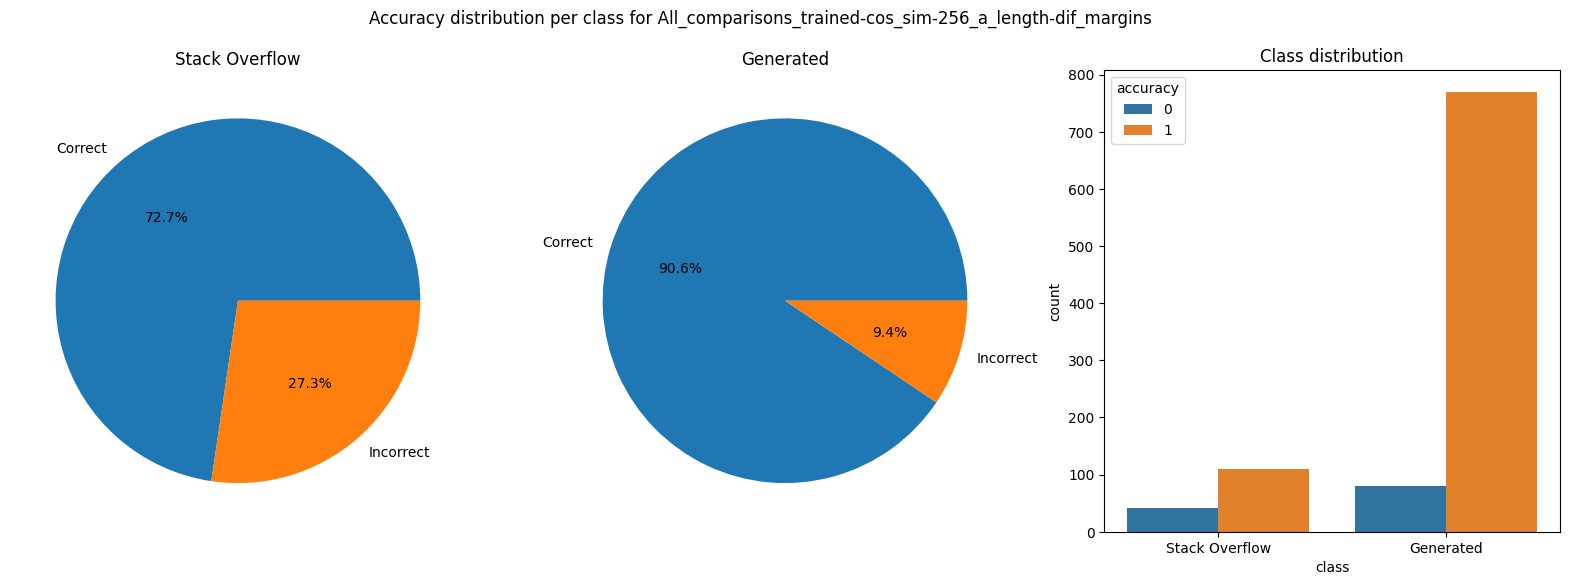

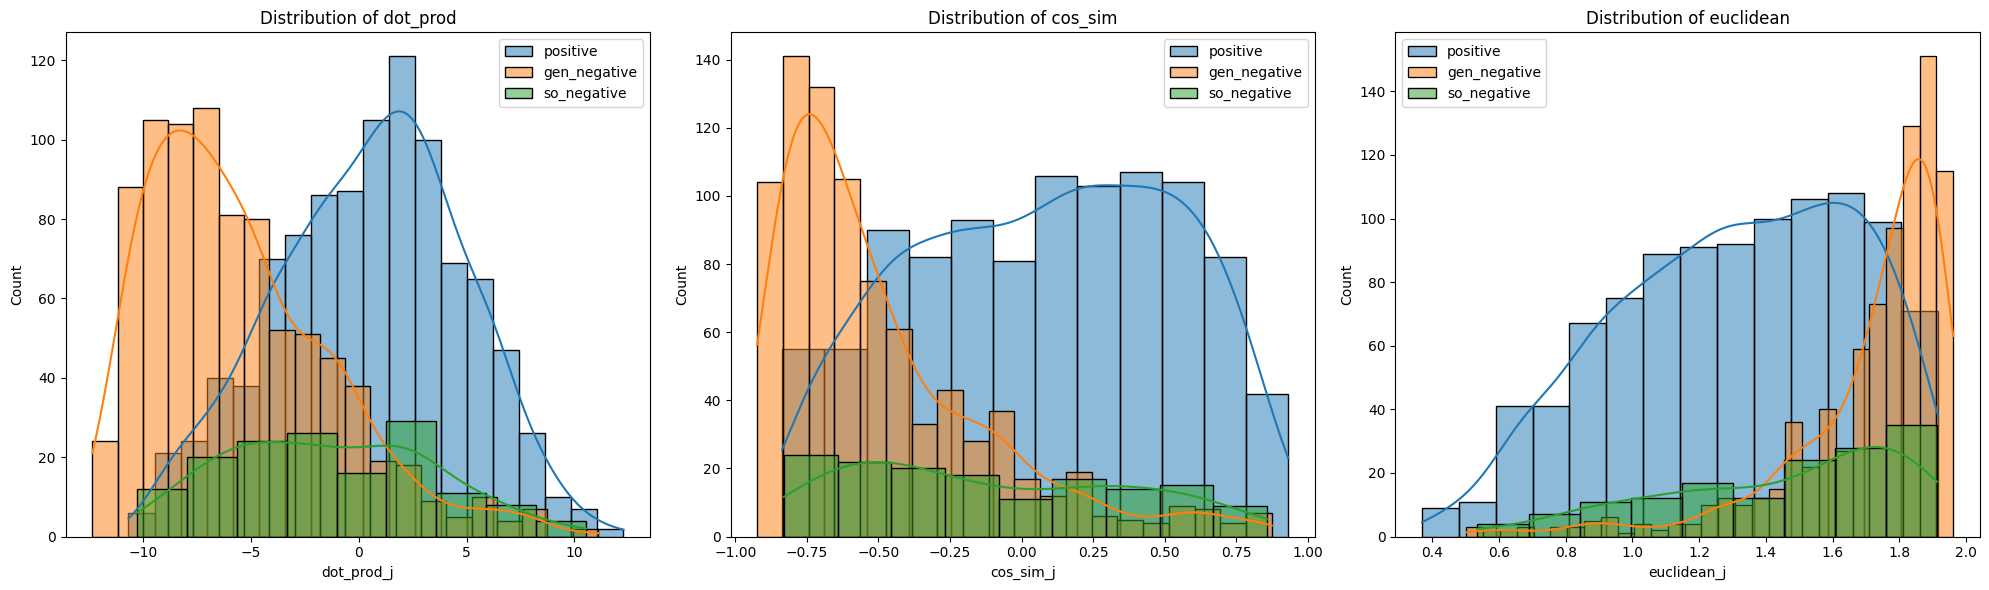

In [37]:
accuracy_report(all_trained_test_dif_margin_v2_all_df, "All_comparisons_trained-cos_sim-256_a_length-dif_margins")
plot_distribution(all_trained_test_dif_margin_v2_all_df)

Accuracy for Stack Overflow: 67.33%
Accuracy for Generated: 92.94%
Overall Accuracy: 89.10%

Average Class Accuracy: 80.14%

Correlations for negative:
Correlation between log_score and dot_prod: 0.56
Correlation between log_score and cos_sim: 0.51
Correlation between log_score and euclidean: -0.55

Correlations for positive:
Correlation between log_score and dot_prod: 0.17
Correlation between log_score and cos_sim: 0.13
Correlation between log_score and euclidean: -0.15


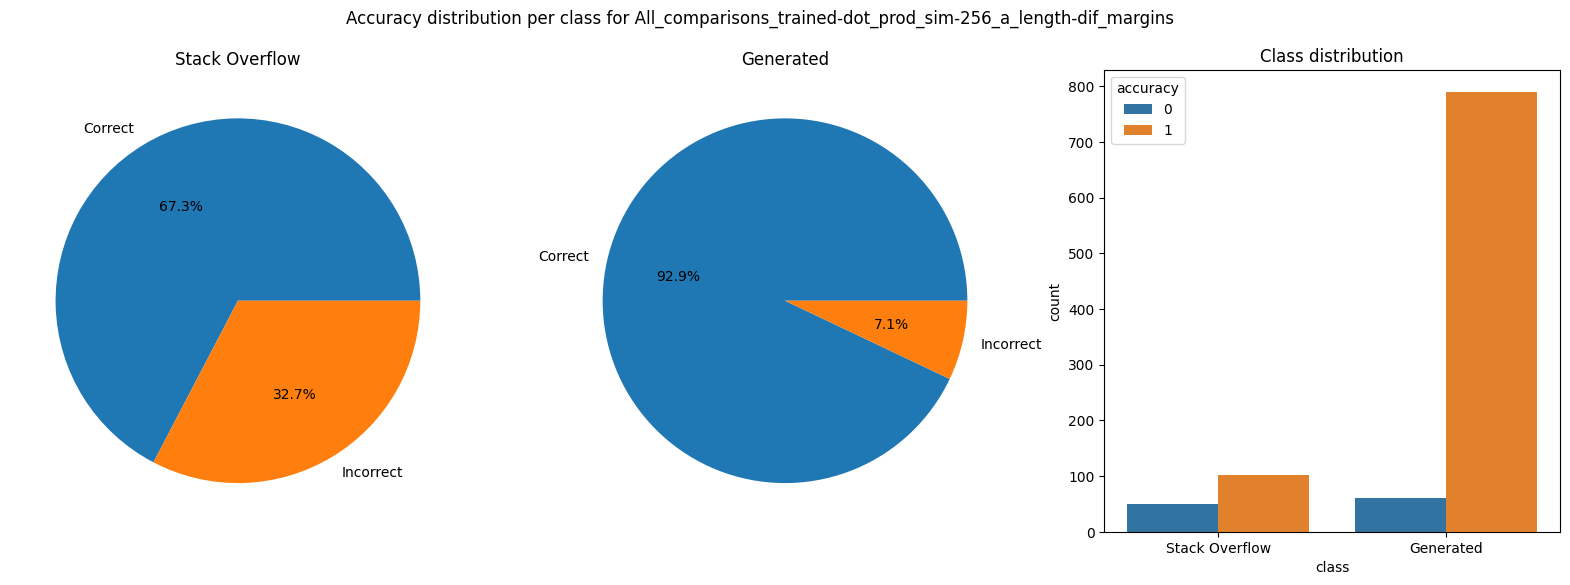

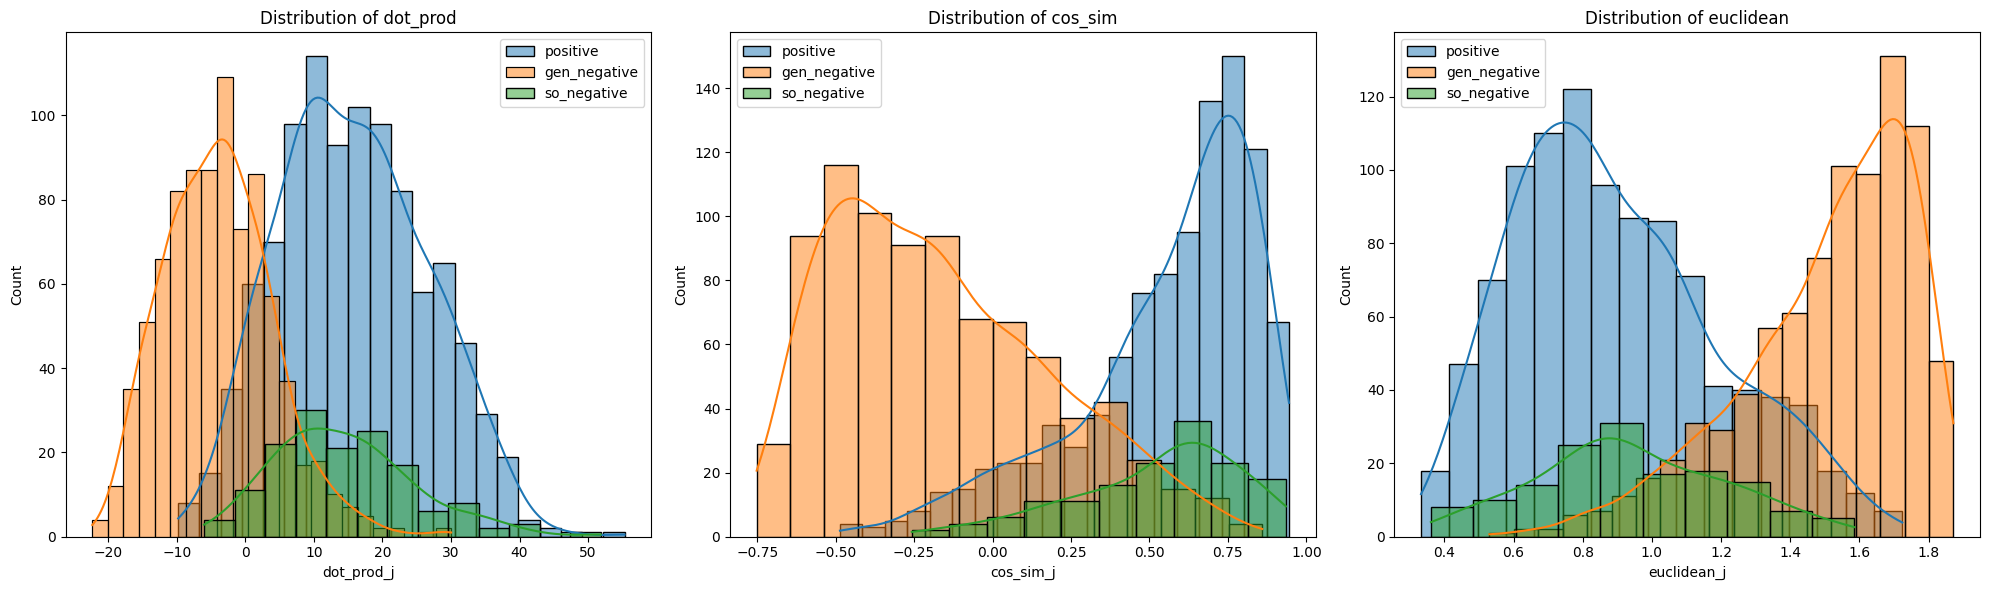

In [32]:
accuracy_report(all_trained_test_dif_margin_dot_prod_all_df, "All_comparisons_trained-dot_prod_sim-256_a_length-dif_margins")
plot_distribution(all_trained_test_dif_margin_dot_prod_all_df)

Accuracy for Generated: 83.08%
Accuracy for Stack Overflow: 70.51%
Overall Accuracy: 82.10%

Average Class Accuracy: 76.80%

Correlations for negative:
Correlation between log_score and dot_prod: 0.18
Correlation between log_score and cos_sim: 0.19
Correlation between log_score and euclidean: -0.19

Correlations for positive:
Correlation between log_score and dot_prod: 0.15
Correlation between log_score and cos_sim: 0.16
Correlation between log_score and euclidean: -0.17


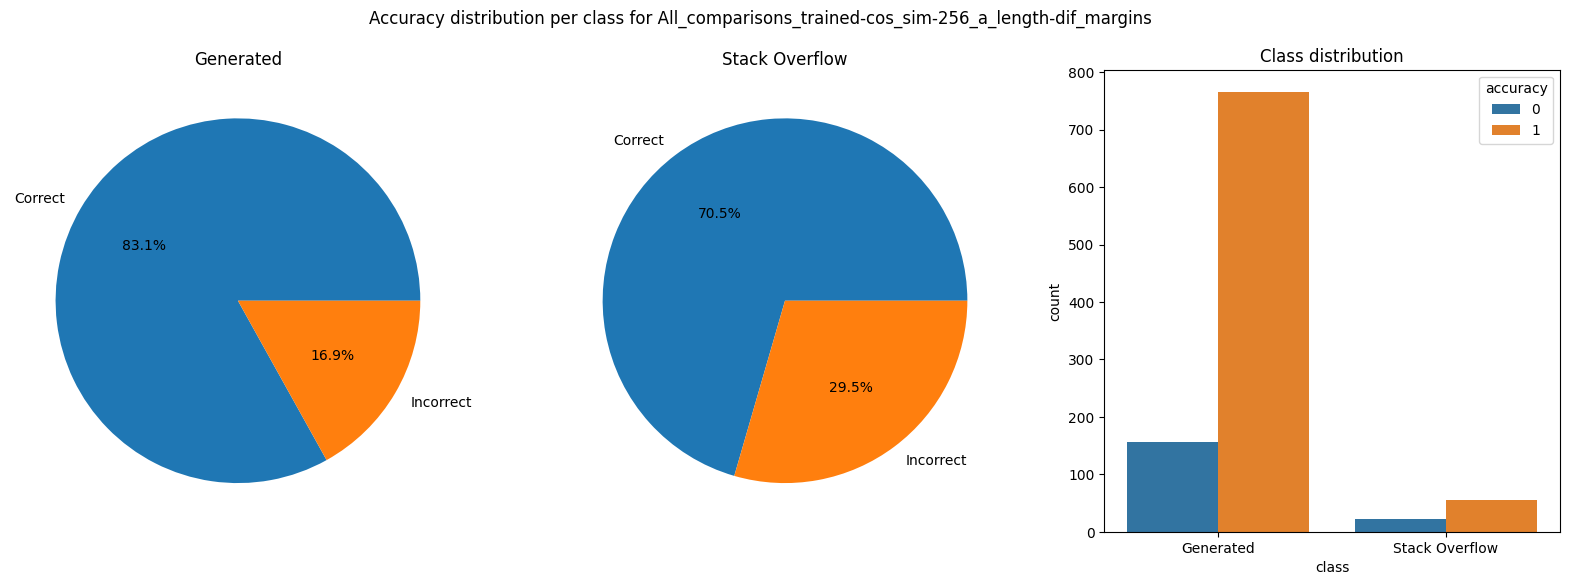

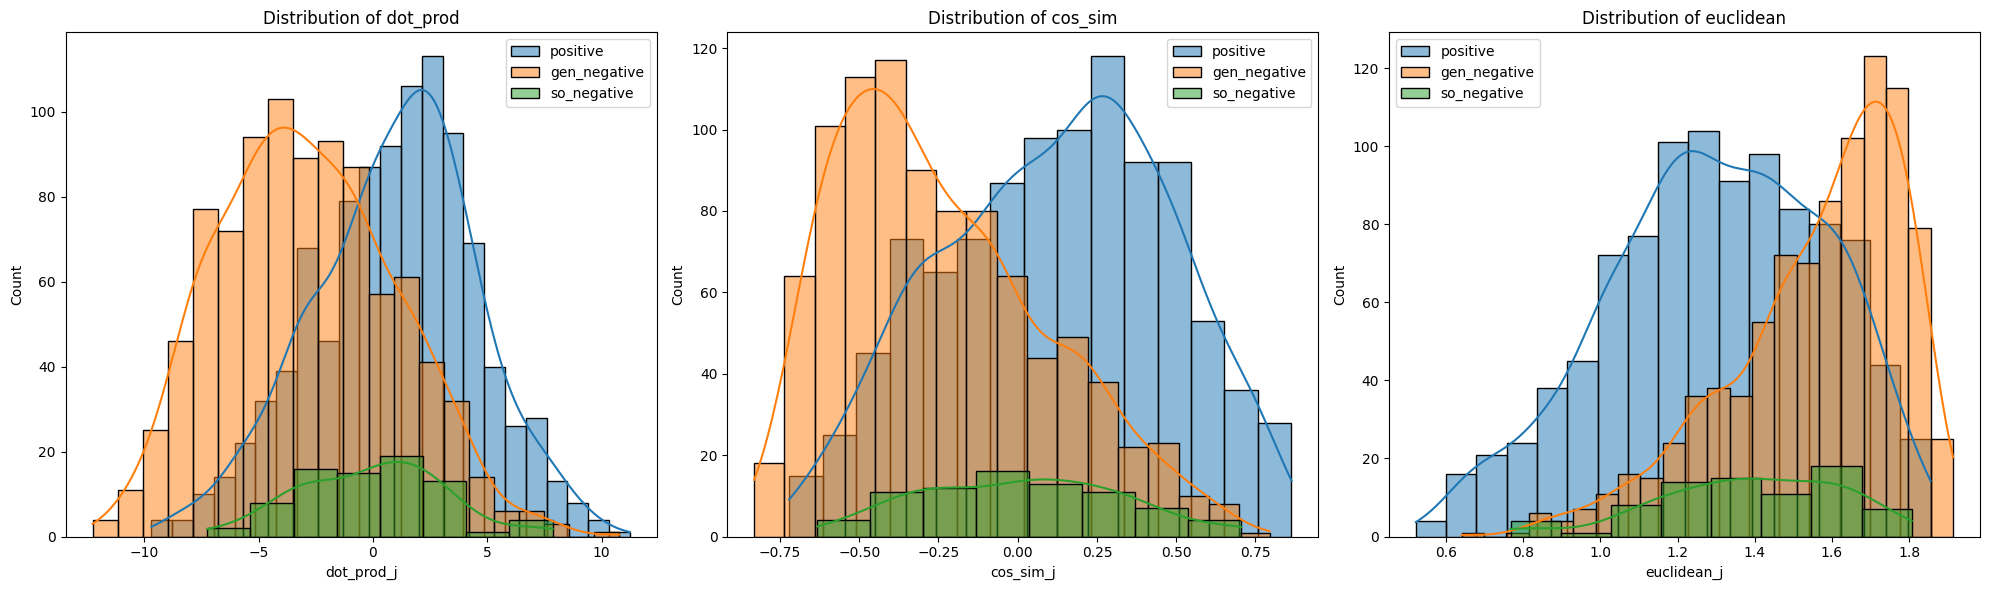

In [33]:
accuracy_report(all_trained_test_dif_margin_all_df, "All_comparisons_trained-cos_sim-256_a_length-dif_margins")
plot_distribution(all_trained_test_dif_margin_all_df)

#### 07.08.2023

##### Test loss SO Negative and Anchor

Accuracy for Generated: 78.74%
Accuracy for Stack Overflow: 50.00%
Overall Accuracy: 76.50%

Average Class Accuracy: 64.37%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.17
Correlation between log_score and cos_sim: 0.15
Correlation between log_score and euclidean: -0.14

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.02
Correlation between log_score and cos_sim: 0.02
Correlation between log_score and euclidean: -0.02

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: 0.11
Correlation between log_score and cos_sim: 0.08
Correlation between log_score and euclidean: -0.08


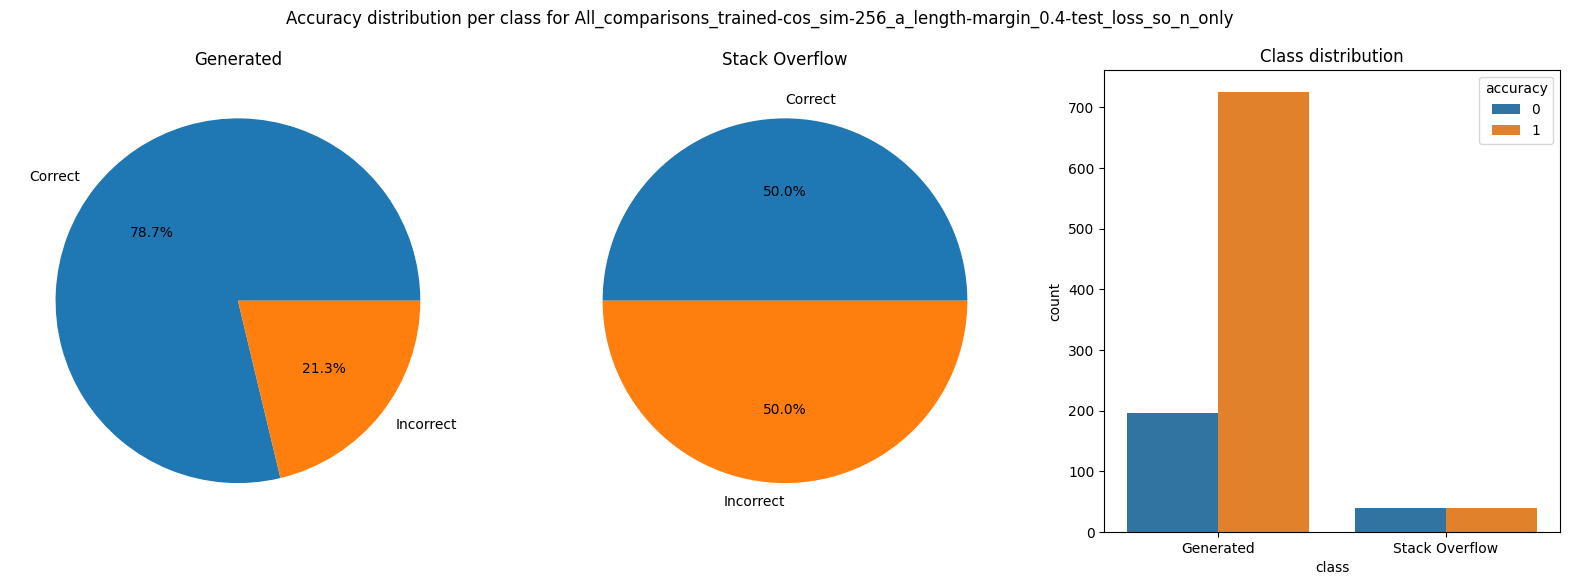

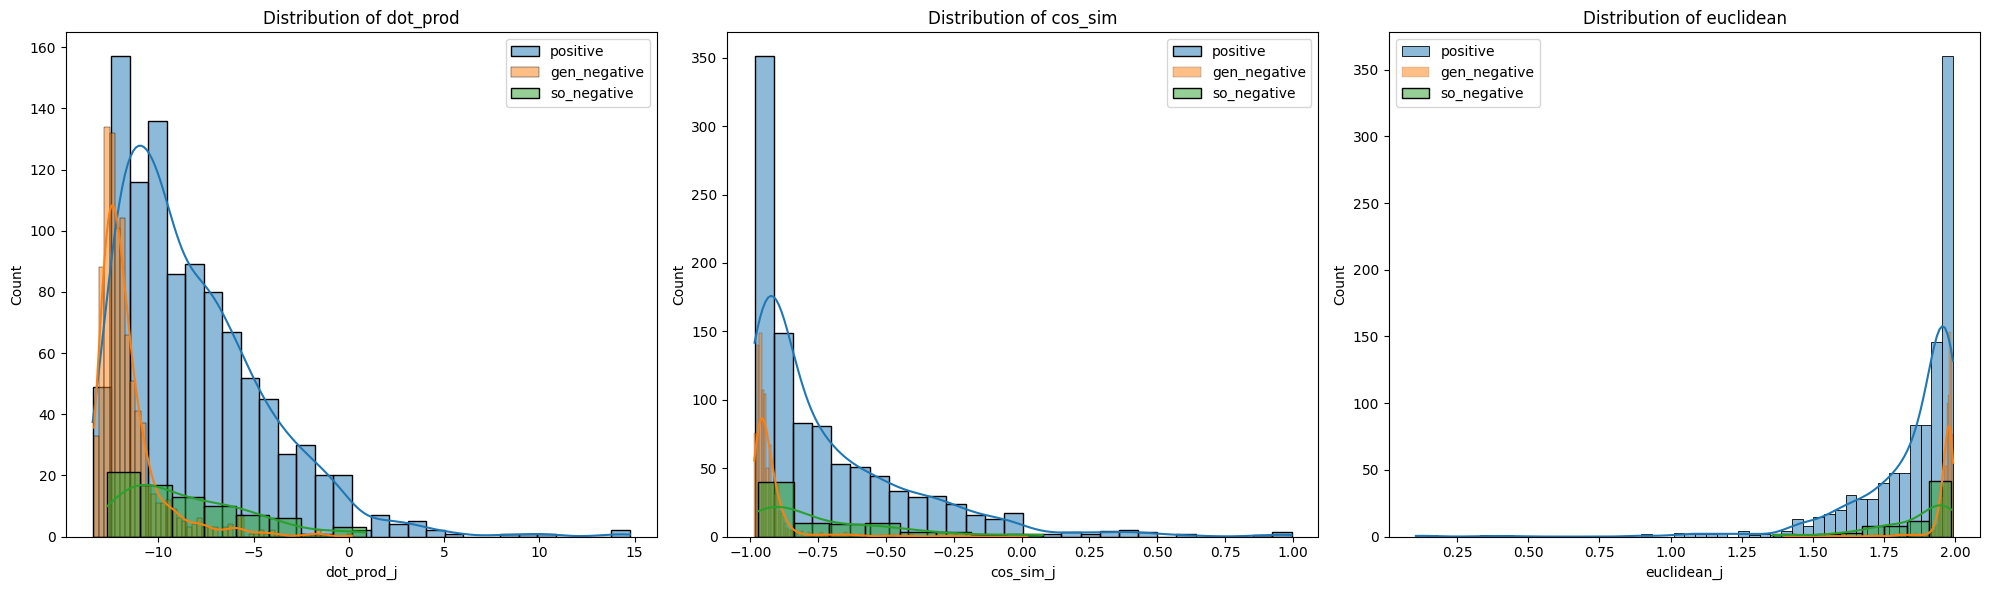

In [59]:
accuracy_report(all_trained_test_loss_n_so_only_all_df, "All_comparisons_trained-cos_sim-256_a_length-margin_0.4-test_loss_so_n_only")
plot_distribution(all_trained_test_loss_n_so_only_all_df)

##### Test loss Positive and Negative

Accuracy for Generated: 92.95%
Accuracy for Stack Overflow: 56.41%
Overall Accuracy: 90.10%

Average Class Accuracy: 74.68%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.12
Correlation between log_score and cos_sim: 0.14
Correlation between log_score and euclidean: -0.11

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.03
Correlation between log_score and cos_sim: 0.03
Correlation between log_score and euclidean: -0.03

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: 0.02
Correlation between log_score and cos_sim: 0.02
Correlation between log_score and euclidean: -0.01


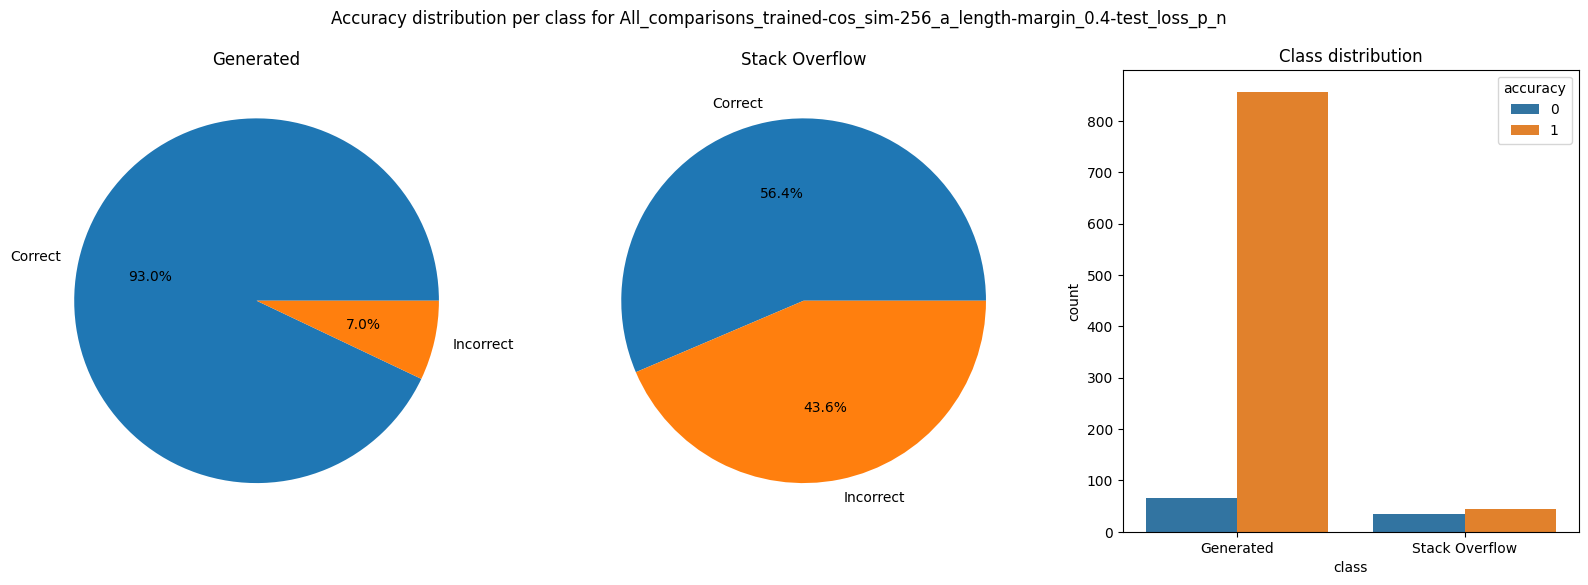

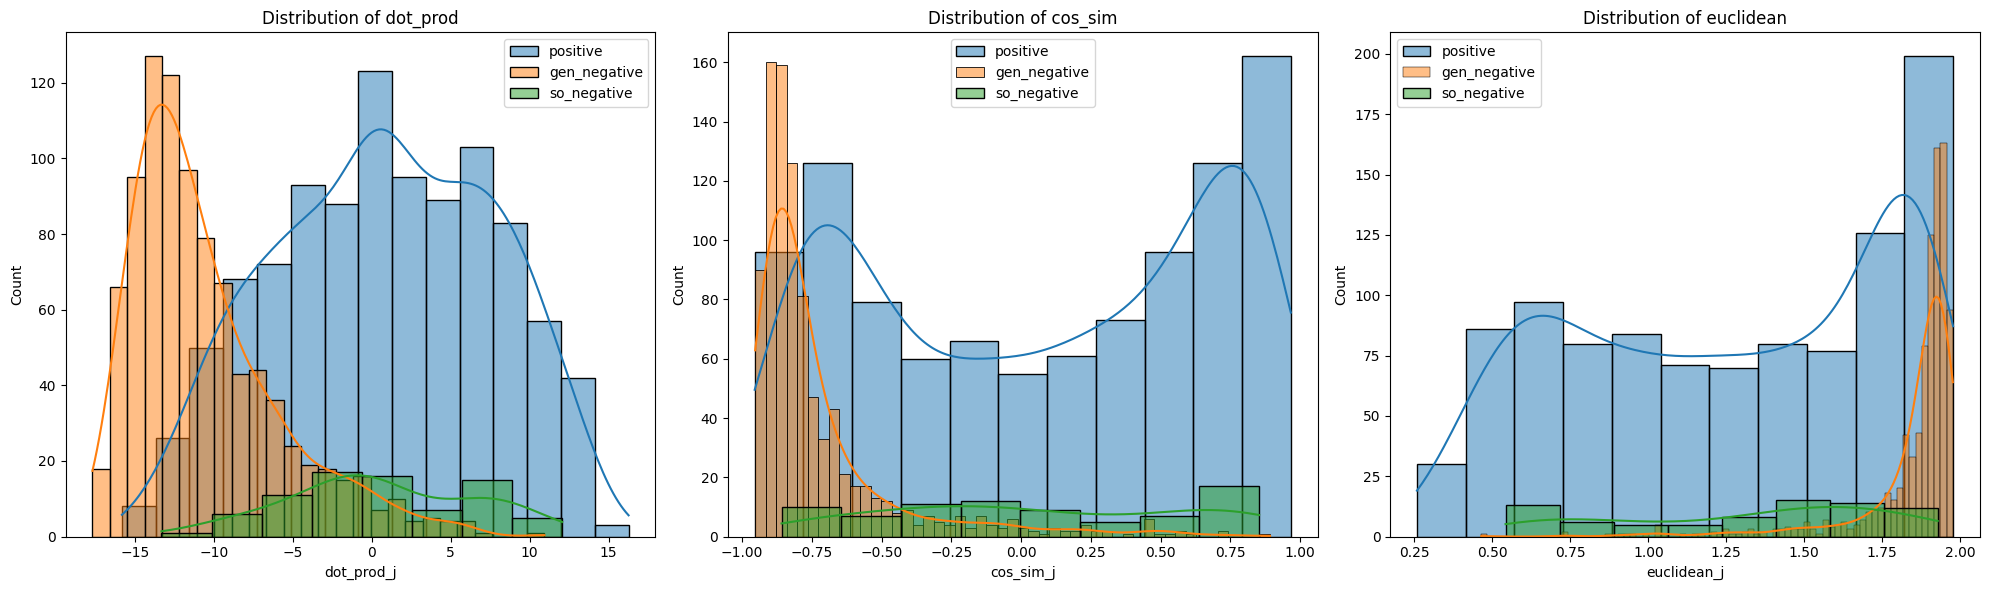

In [60]:
accuracy_report(all_trained_test_loss_p_n_all_df, "All_comparisons_trained-cos_sim-256_a_length-margin_0.4-test_loss_p_n")
plot_distribution(all_trained_test_loss_p_n_all_df)

##### Margin 0.5 Cos Distance

Accuracy for Generated: 94.69%
Accuracy for Stack Overflow: 58.97%
Overall Accuracy: 91.90%

Average Class Accuracy: 76.83%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.15
Correlation between log_score and cos_sim: 0.18
Correlation between log_score and euclidean: -0.17

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.05
Correlation between log_score and cos_sim: 0.06
Correlation between log_score and euclidean: -0.07

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: -0.02
Correlation between log_score and cos_sim: 0.01
Correlation between log_score and euclidean: -0.02


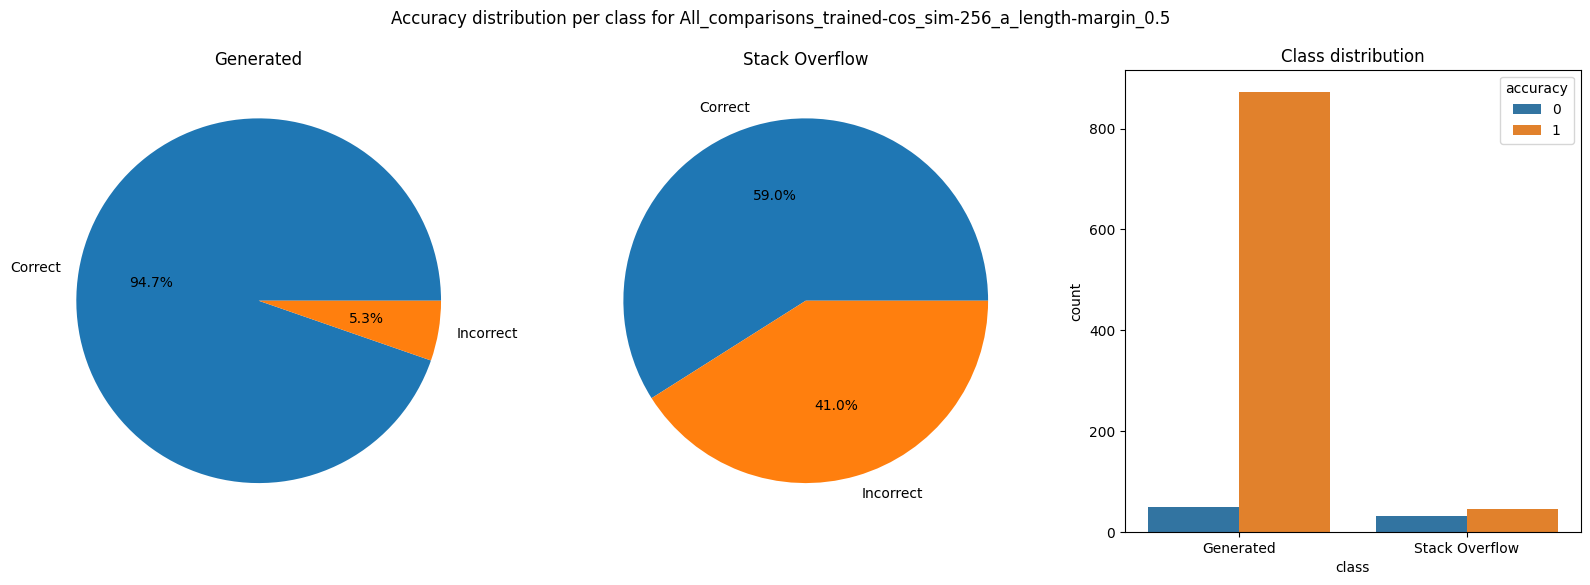

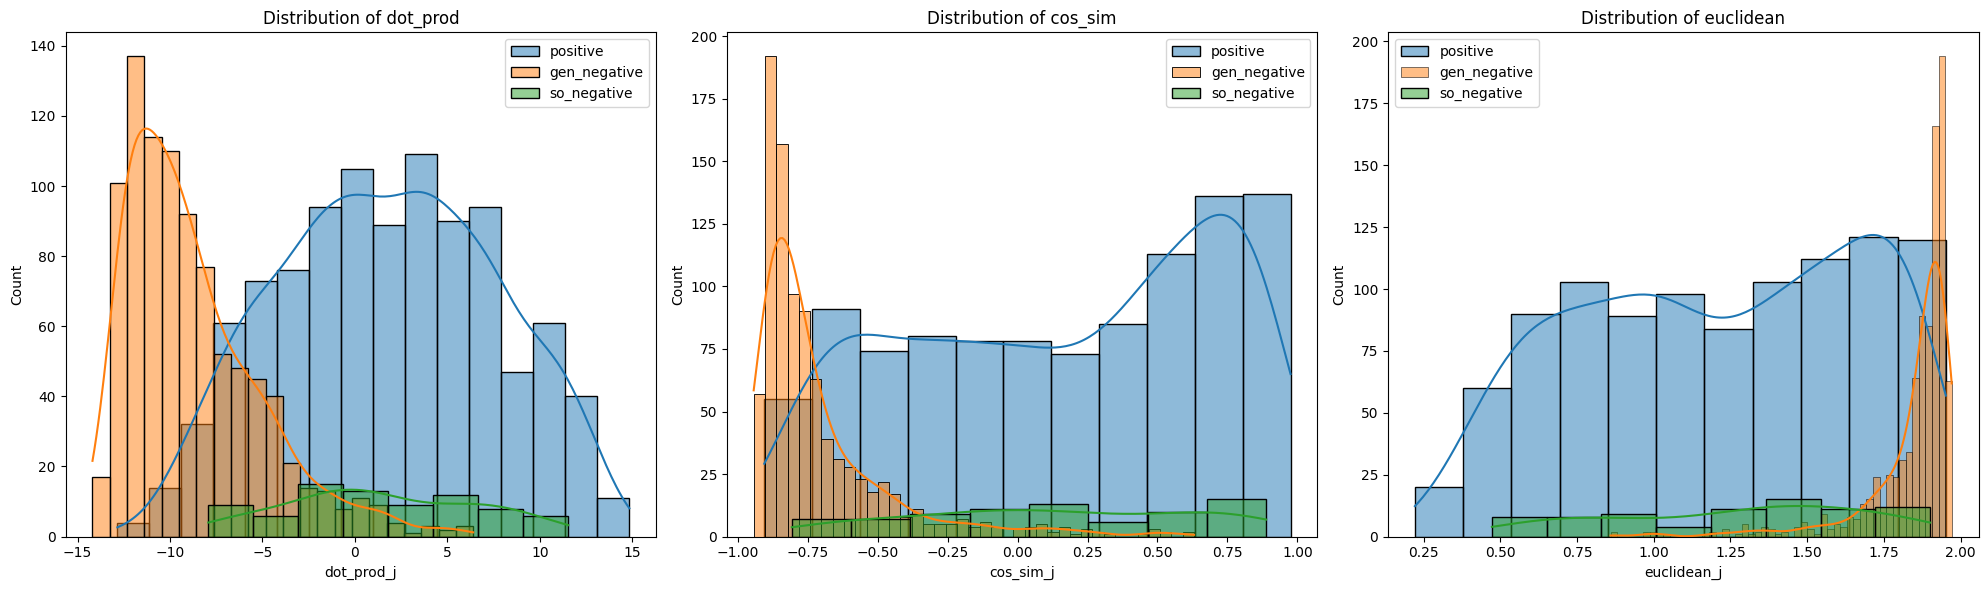

In [61]:
accuracy_report(all_trained_m_05_all_df, "All_comparisons_trained-cos_sim-256_a_length-margin_0.5")
plot_distribution(all_trained_m_05_all_df)

#### 05.08.2023

##### Margin 0.35, Cos Distance, Max Answer length 256

Accuracy for Generated: 93.60%
Accuracy for Stack Overflow: 61.54%
Overall Accuracy: 91.10%

Average Class Accuracy: 77.57%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.15
Correlation between log_score and cos_sim: 0.18
Correlation between log_score and euclidean: -0.16

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.04
Correlation between log_score and cos_sim: 0.05
Correlation between log_score and euclidean: -0.05

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: 0.02
Correlation between log_score and cos_sim: 0.03
Correlation between log_score and euclidean: -0.03


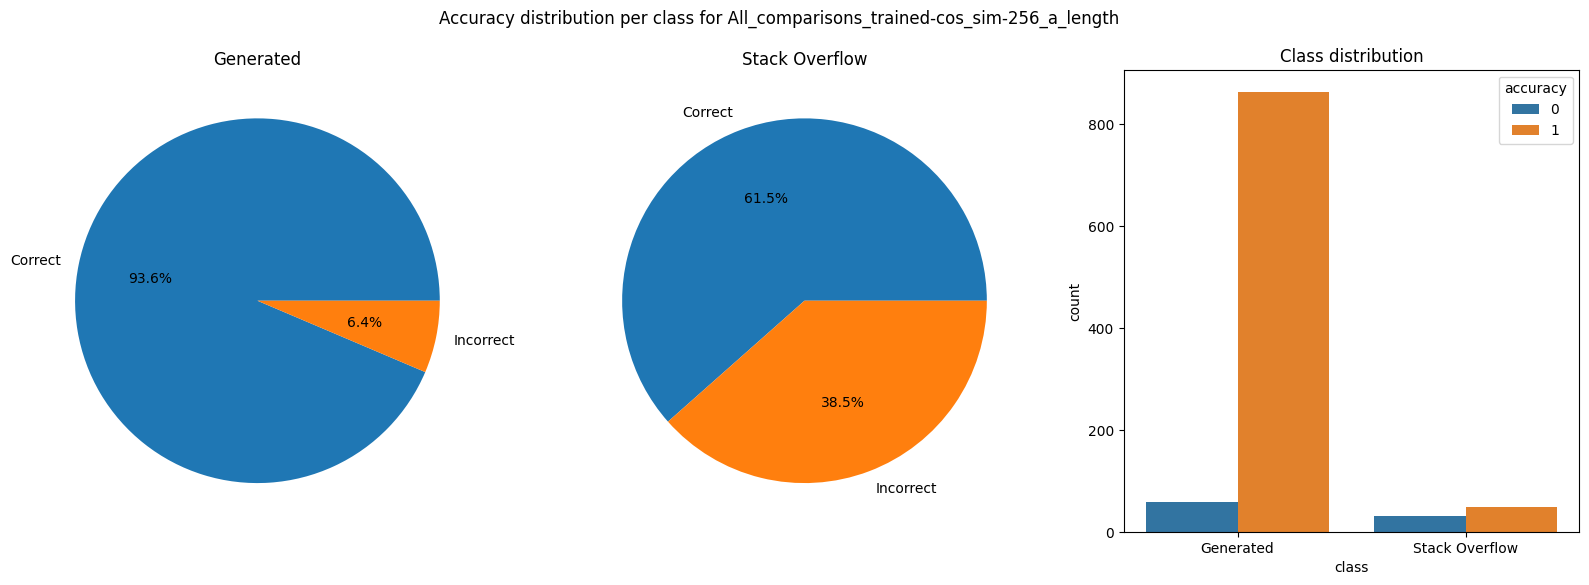

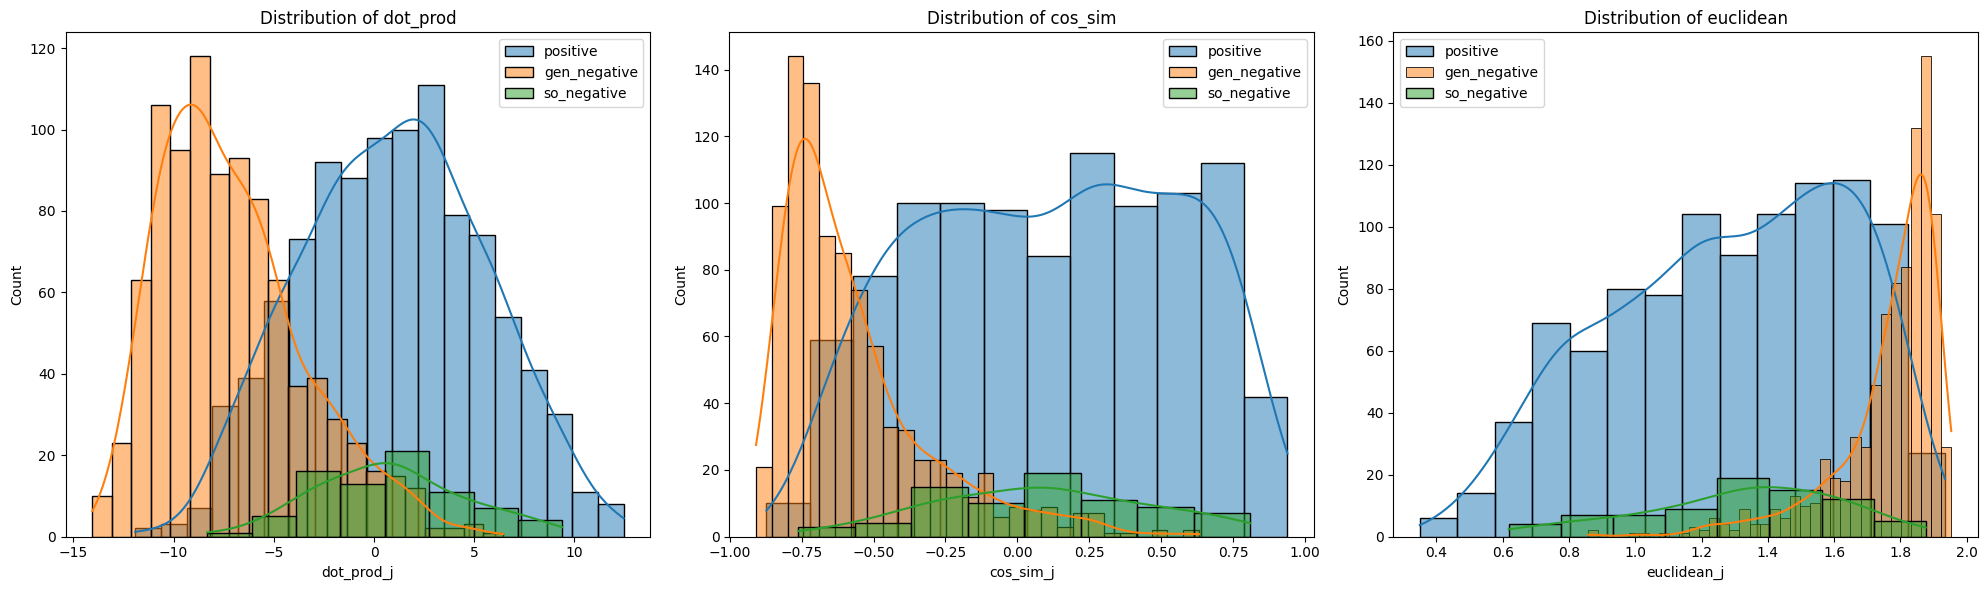

In [62]:
accuracy_report(all_trained_cos_m_l_256_all_df, "All_comparisons_trained-cos_sim-256_a_length")
plot_distribution(all_trained_cos_m_l_256_all_df)

##### Margin 0.35, Cos Distance

Accuracy for Generated: 93.93%
Accuracy for Stack Overflow: 58.97%
Overall Accuracy: 91.20%

Average Class Accuracy: 76.45%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.19
Correlation between log_score and cos_sim: 0.22
Correlation between log_score and euclidean: -0.21

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.06
Correlation between log_score and cos_sim: 0.07
Correlation between log_score and euclidean: -0.07

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: 0.05
Correlation between log_score and cos_sim: 0.04
Correlation between log_score and euclidean: -0.05


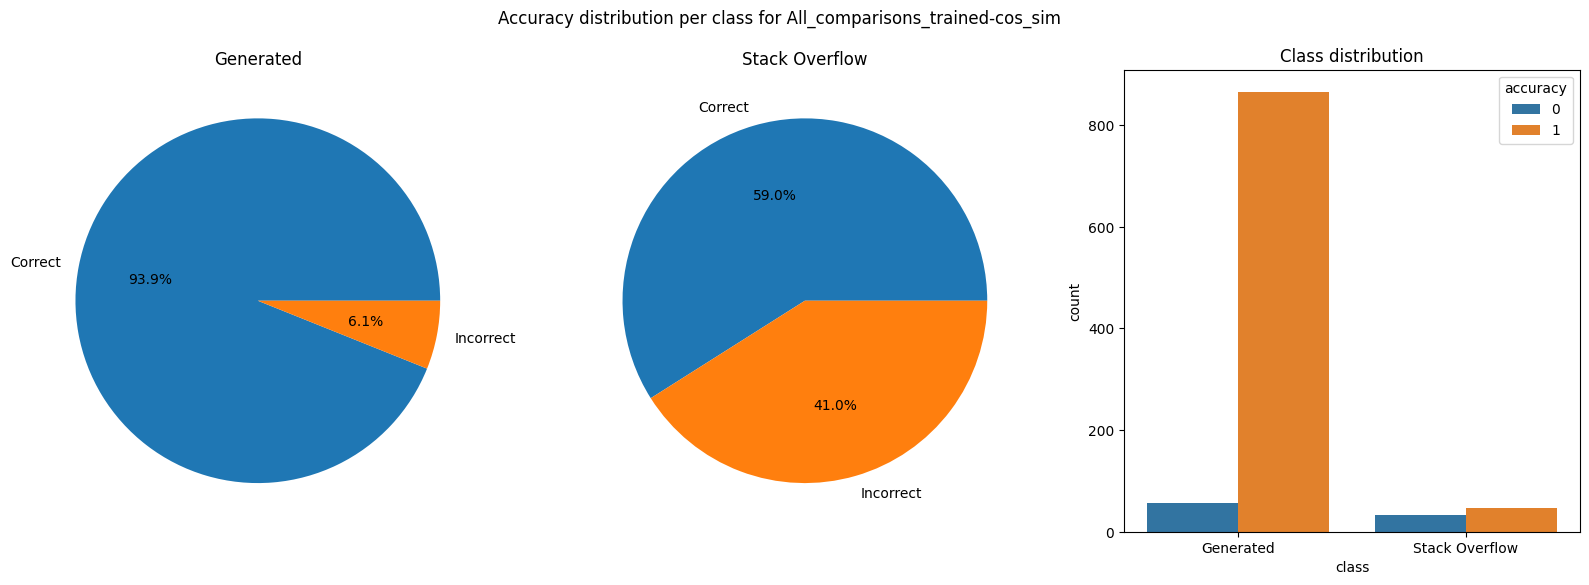

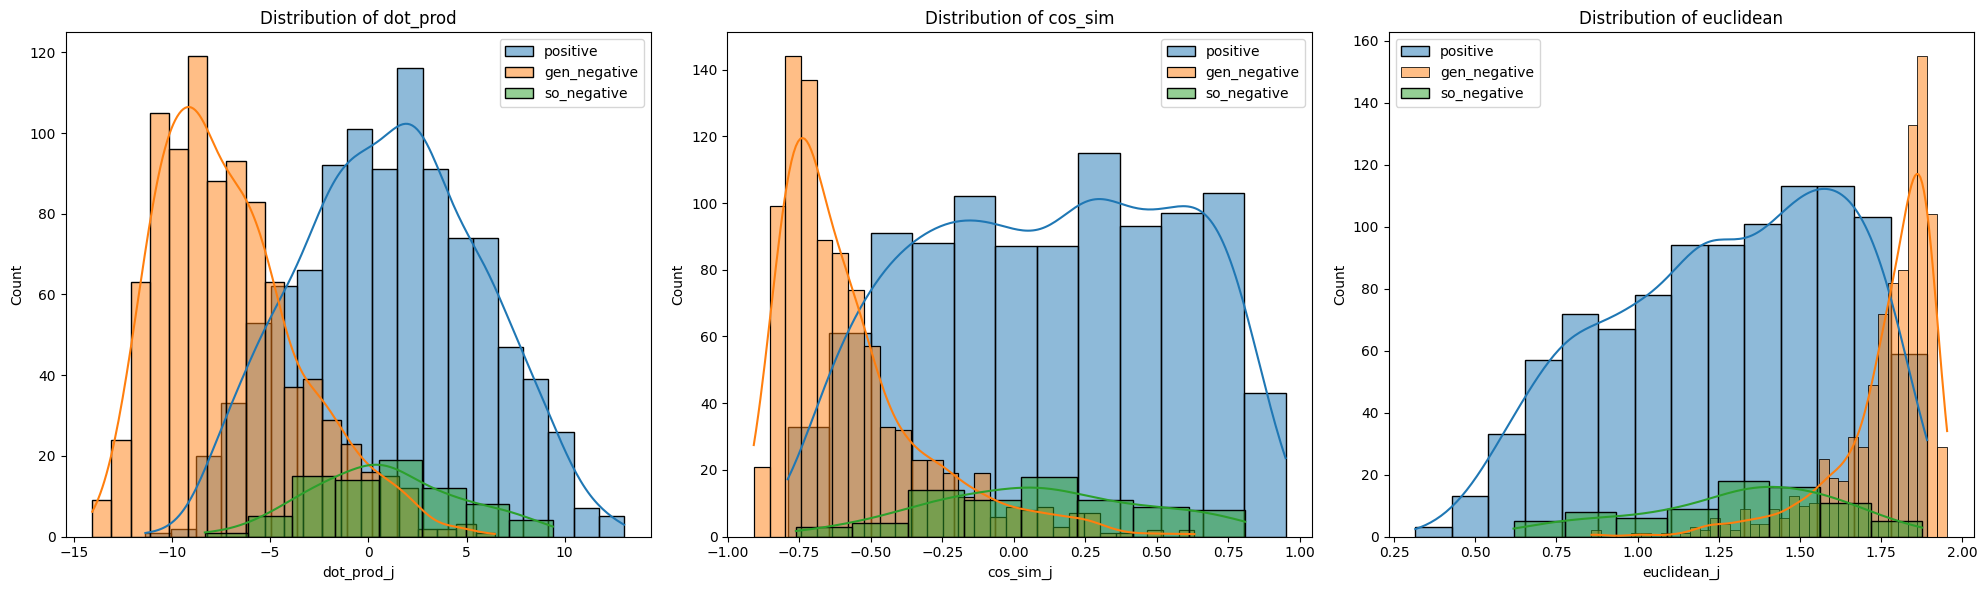

In [63]:
accuracy_report(all_trained_cos_all_df, "All_comparisons_trained-cos_sim")
plot_distribution(all_trained_cos_all_df)

##### Margin 0.35, L2 norm

Accuracy for Generated: 89.70%
Accuracy for Stack Overflow: 50.00%
Overall Accuracy: 86.60%

Average Class Accuracy: 69.85%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.17
Correlation between log_score and cos_sim: 0.19
Correlation between log_score and euclidean: -0.19

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.05
Correlation between log_score and cos_sim: 0.05
Correlation between log_score and euclidean: -0.06

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: 0.11
Correlation between log_score and cos_sim: 0.11
Correlation between log_score and euclidean: -0.11


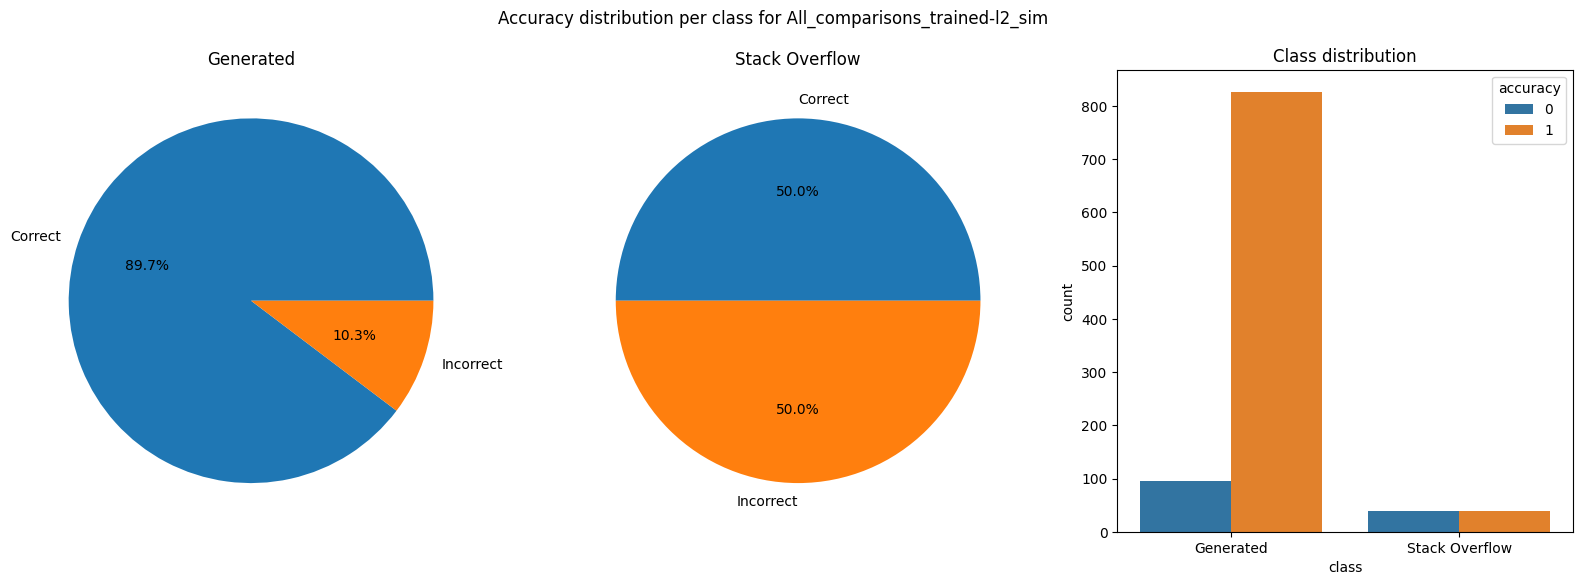

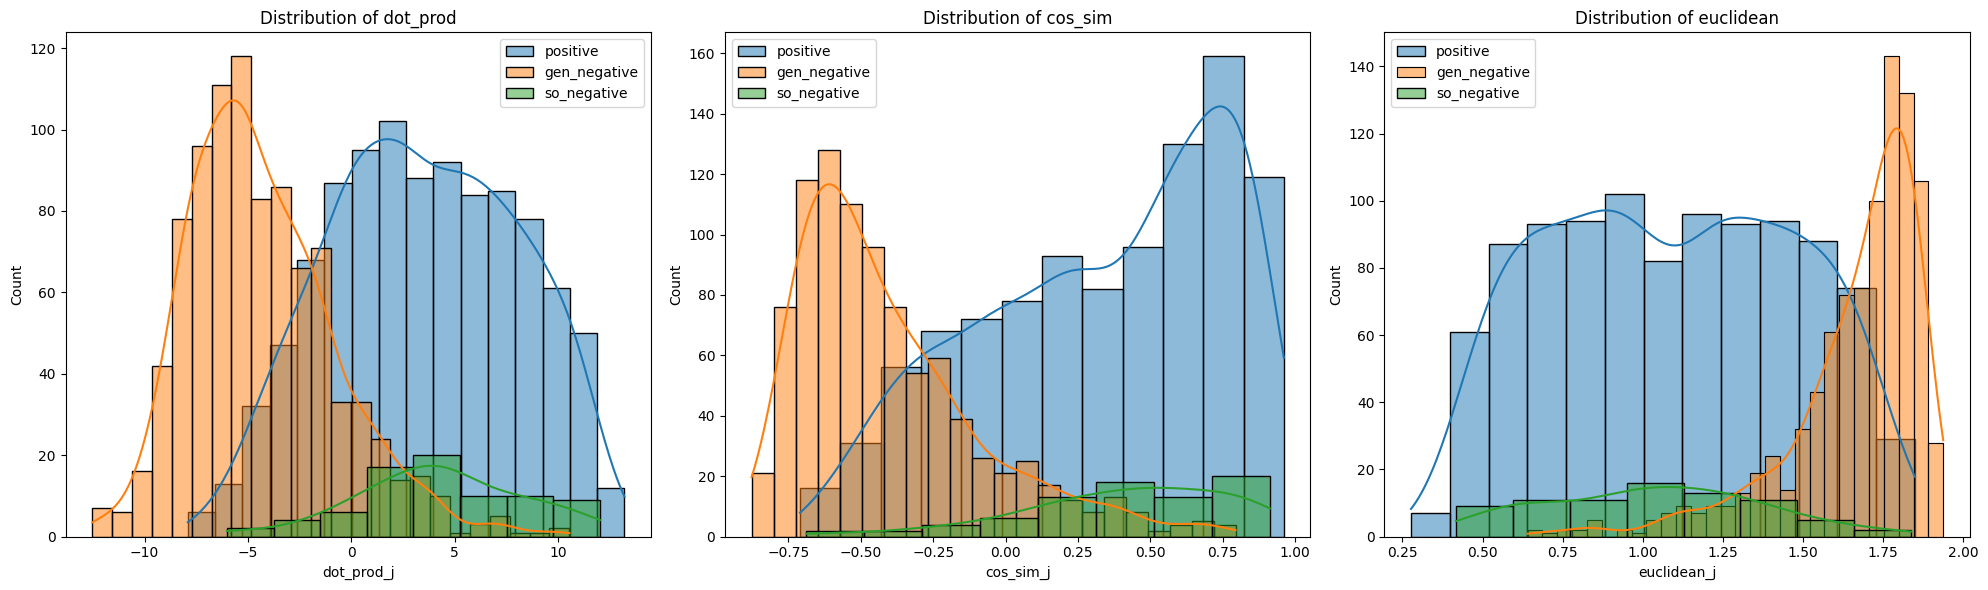

In [64]:
accuracy_report(all_trained_l2_all_df, "All_comparisons_trained-l2_sim")
plot_distribution(all_trained_l2_all_df)

##### Trained on SO only, Margin 0.55 Cos Distance

Accuracy for Generated: 52.82%
Accuracy for Stack Overflow: 76.92%
Overall Accuracy: 54.70%

Average Class Accuracy: 64.87%

Correlations for negative_gen:
Correlation between log_score and dot_prod: nan
Correlation between log_score and cos_sim: nan
Correlation between log_score and euclidean: nan

Correlations for negative_gen_so:
Correlation between log_score and dot_prod: 0.08
Correlation between log_score and cos_sim: 0.09
Correlation between log_score and euclidean: -0.08

Correlations for positive_gen:
Correlation between log_score and dot_prod: 0.16
Correlation between log_score and cos_sim: 0.15
Correlation between log_score and euclidean: -0.15

Correlations for positive_gen_so:
Correlation between log_score and dot_prod: 0.10
Correlation between log_score and cos_sim: 0.12
Correlation between log_score and euclidean: -0.09


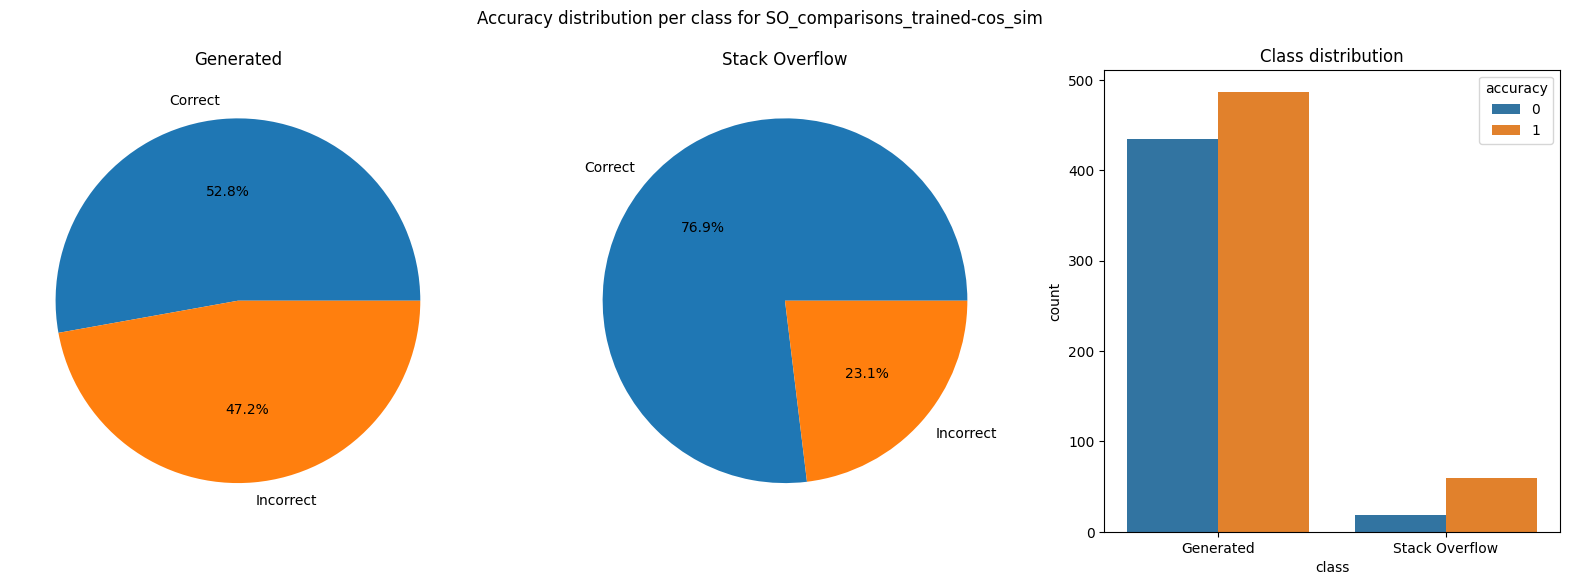

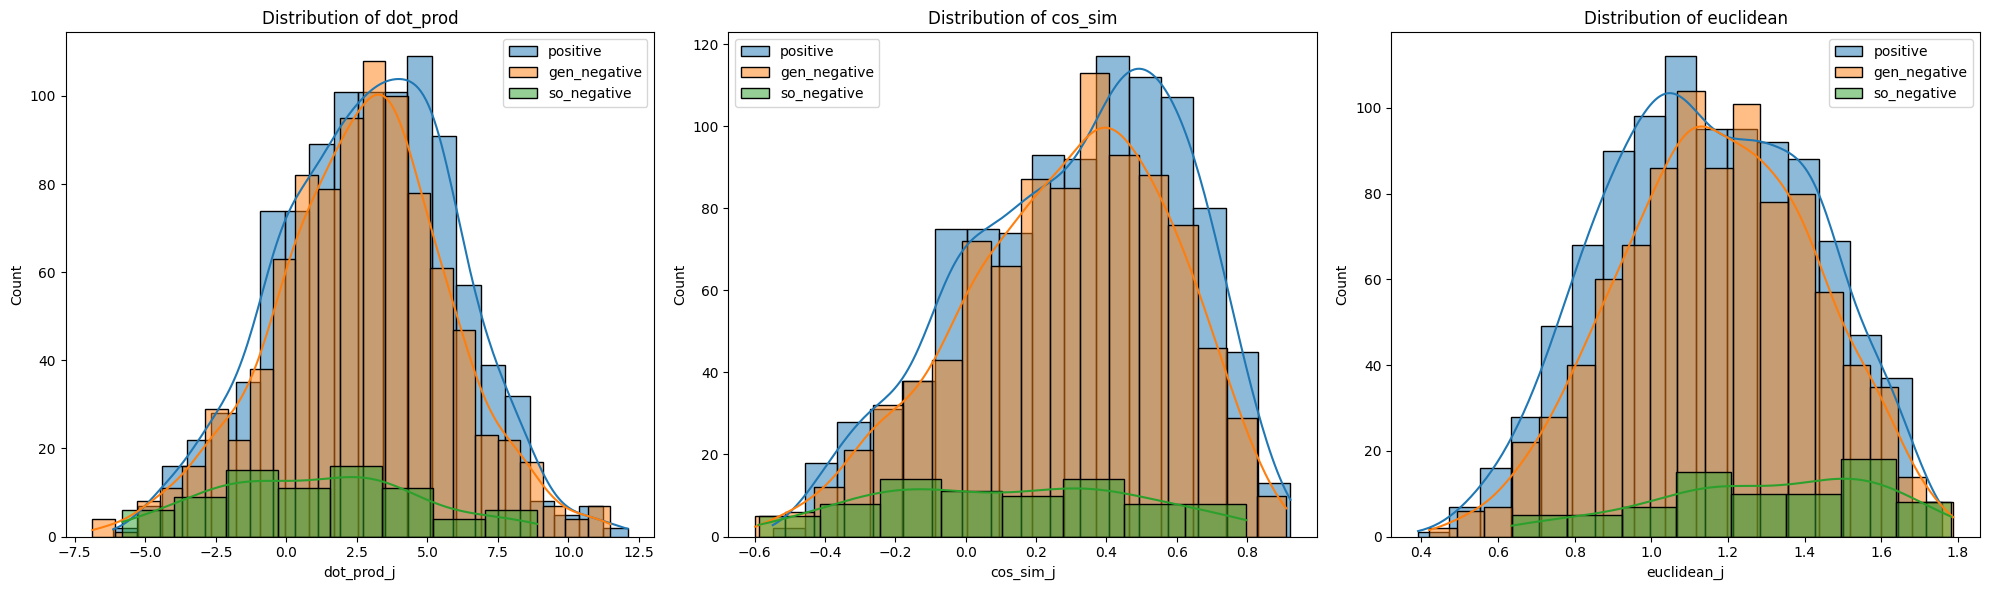

In [65]:
accuracy_report(so_trained_cos_all_df, "SO_comparisons_trained-cos_sim")
plot_distribution(so_trained_cos_all_df)

### SO answers eval

In [22]:
so_trained_cos_so_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_so/test-mpnet-so_only-lr_2e5-not_norm-margin_0.55-all-cos_dist-fr_1_10_11.csv")
all_trained_cos_so_df = pd.read_csv("/home/st-gorbatovski/sollama/src/mpnet_reward/artifacts/tests/trained_on_all/test-mpnet-so_only-lr_2e5-not_norm-margin_0.35-all-cos_dist-fr_1_11.csv")

#### 05.08.2023

##### Trained on SO only, Margin 0.55 Cos Distance

Accuracy for Stack Overflow: 68.10%
Overall Accuracy: 68.10%

Average Class Accuracy: 68.10%

Correlations for negative_so:
Correlation between log_score and dot_prod: 0.24
Correlation between log_score and cos_sim: 0.24
Correlation between log_score and euclidean: -0.24

Correlations for positive_so:
Correlation between log_score and dot_prod: 0.26
Correlation between log_score and cos_sim: 0.25
Correlation between log_score and euclidean: -0.26


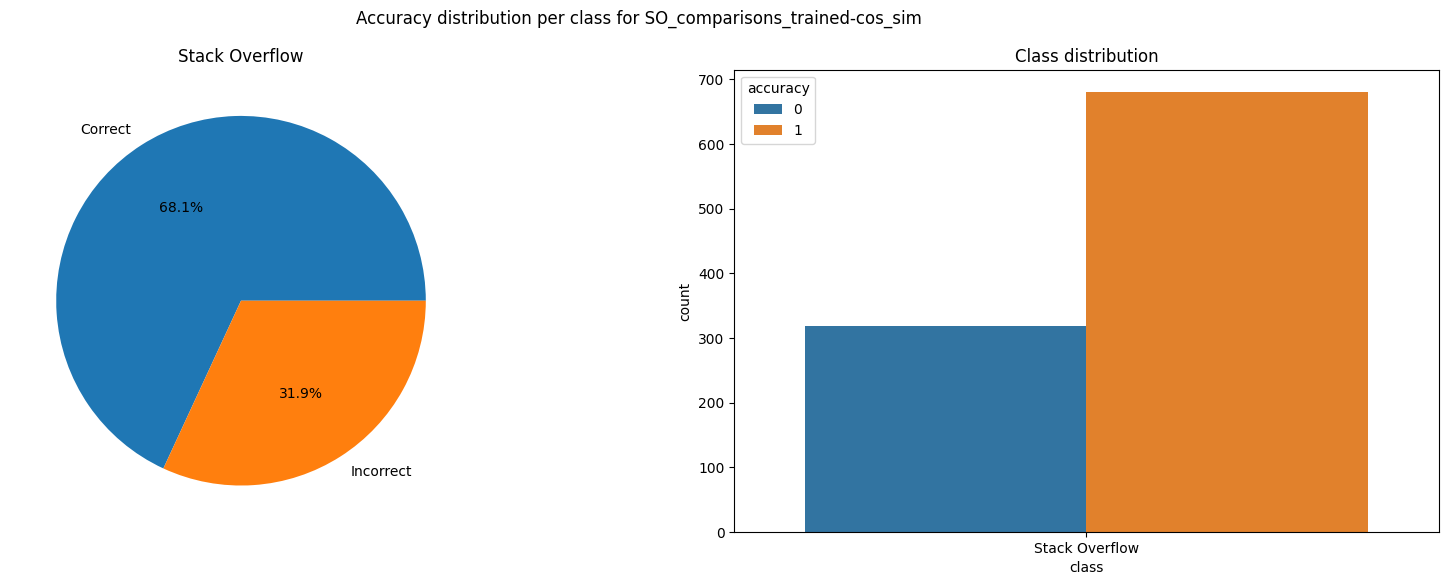

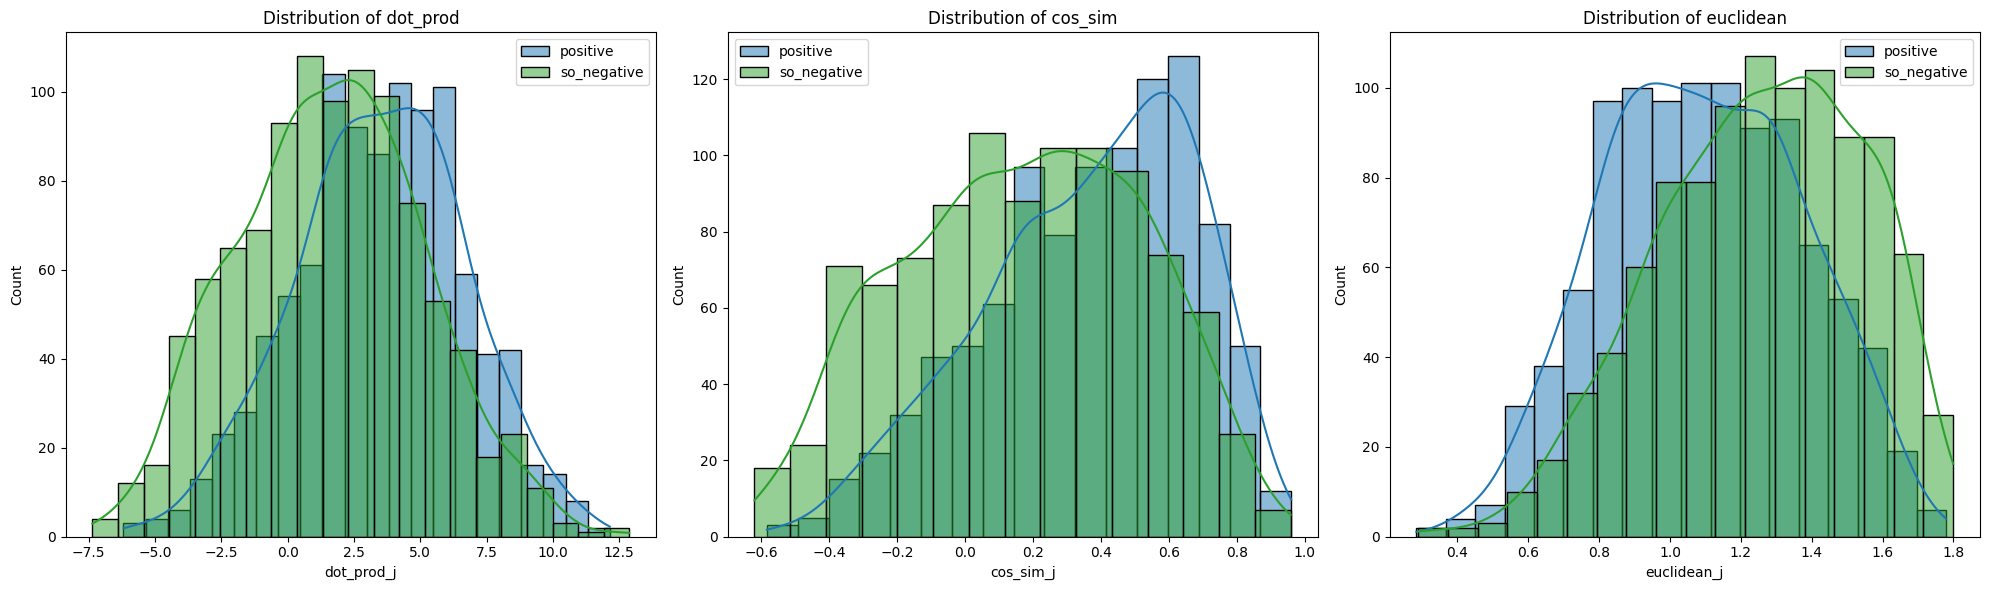

In [67]:
accuracy_report(so_trained_cos_so_df, "SO_comparisons_trained-cos_sim")
plot_distribution(so_trained_cos_so_df)

**Возможна утечка данных**

##### Margin 0.35 Cos Distance

Accuracy for Stack Overflow: 75.20%
Overall Accuracy: 75.20%

Average Class Accuracy: 75.20%

Correlations for negative_so:
Correlation between log_score and dot_prod: 0.08
Correlation between log_score and cos_sim: 0.09
Correlation between log_score and euclidean: -0.07

Correlations for positive_so:
Correlation between log_score and dot_prod: 0.06
Correlation between log_score and cos_sim: 0.09
Correlation between log_score and euclidean: -0.07


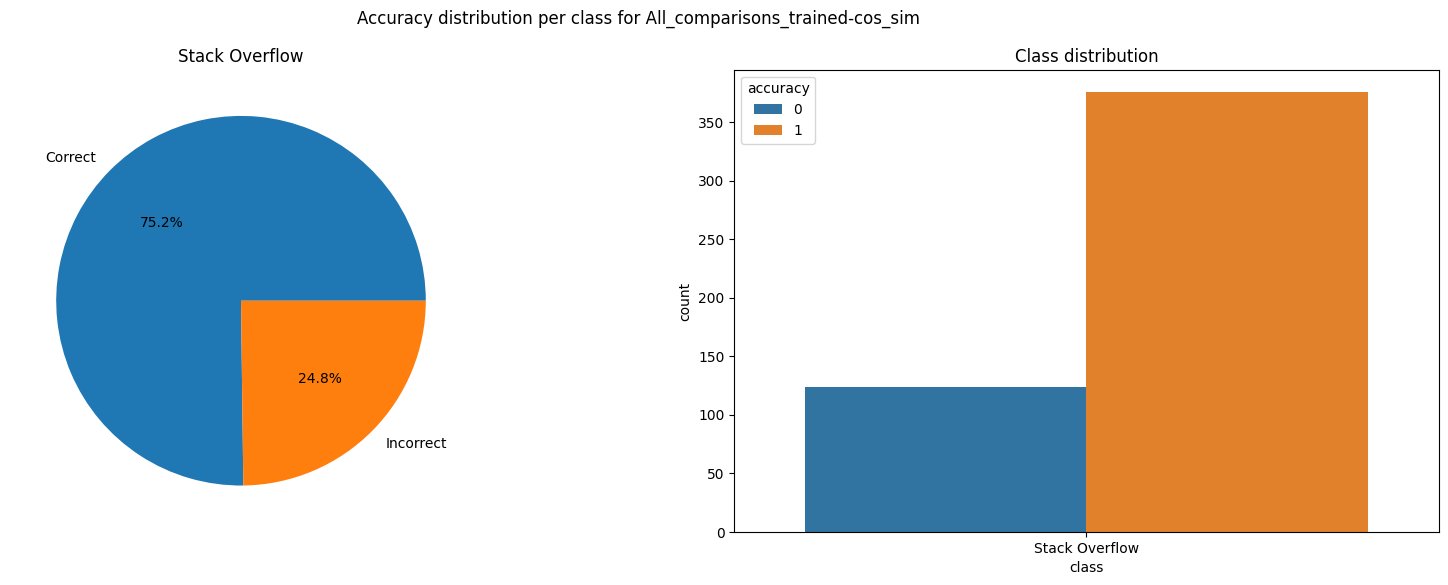

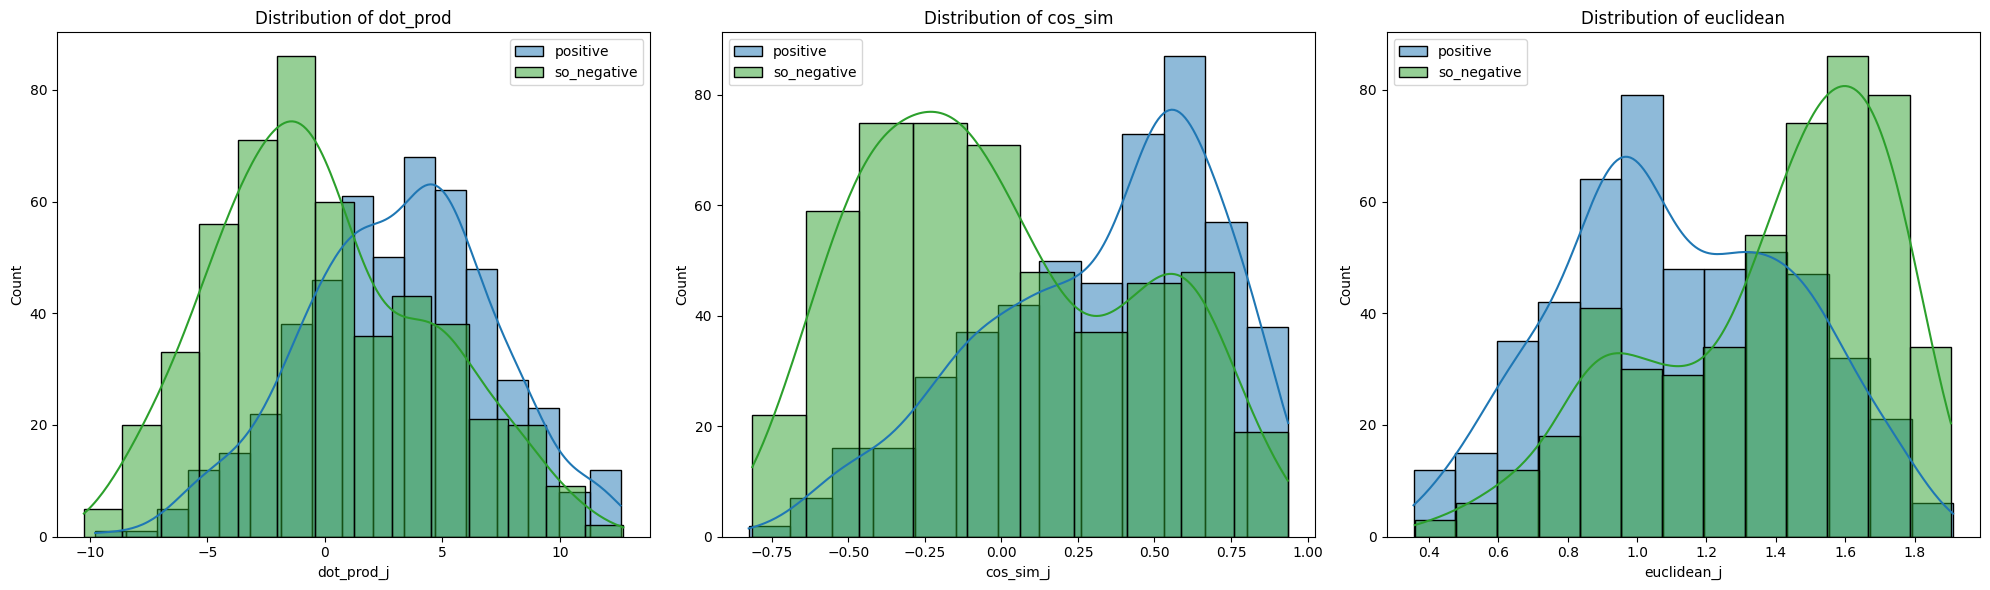

In [68]:
accuracy_report(all_trained_cos_so_df, "All_comparisons_trained-cos_sim")
plot_distribution(all_trained_cos_so_df)